<hr>

Libreta Jupyter del trabajo de investigación

**"Estimación de la evapotranspiración espacio-temporal en olivares (Olea europaea L.) usando imágenes satelitales, Región Tacna, Perú"**

Autor: José Luis Huanuqueño Murillo (JLHM)

Octubre, 2025

<div style="font-size: 0.85em; color: #aab7c4; margin-top: 10px;">
<b><i>Nota de atribución:</i></b> Este cuaderno se basa y adapta el trabajo original de 
Cesar Francisco Vilca Gamarra (2022) desarrollado para arroz en Lambayeque.  
Repositorio fuente: <a href="https://github.com/vilcagamarracf/Inv_arroz_METRIC" style="color:#6ec8d8;">https://github.com/vilcagamarracf/Inv_arroz_METRIC</a>
</div>

<hr>


## 1. Visualizando imágenes
Libreta para seguir el conjunto de imágenes que vayan saliendo para el área de estudio (Olivo – Tacna).


In [2]:
# ==== Header de proyecto (importa módulos de /src y fija rutas) ====
import sys, os
from pathlib import Path

# 1) Detecta la raíz del proyecto buscando la carpeta 'src'
def find_project_root(start: Path, marker="src") -> Path:
    for p in [start, *start.parents]:
        if (p / marker).exists():
            return p
    return start  # fallback

CWD = Path.cwd()
BASE_DIR = find_project_root(CWD, "src")

# 2) Añade /src al path de Python (si no está)
SRC_DIR = BASE_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

In [3]:
%reset -f

In [4]:
# Ruta del directorio de trabajo
# %pwd es un magic de Jupyter que muestra el directorio actual del kernel.
%pwd

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [5]:
import os
os.chdir('c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks')
os.getcwd()

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [5]:
# !pip install earthengine-api --upgrade
# !pip install pycrs
# !pip install geemap
# !pip install numpy
# !pip install shapely --upgrade
# !pip install cartopy

## 2. Importación de librerías y configuración del entorno

In [6]:
# Earth Engine
import ee

import geemap
import geemap.colormaps as cmp # Paletas para visualización de imágenes (cm se confunde con matplotlib)

import pandas as pd
from ipywidgets import interact, fixed
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
# =============================
#  CONFIGURACIÓN FIJA DE ESTILO
# =============================
mpl.rcParams.update({
    "figure.facecolor": "white",      # fondo de figura
    "axes.facecolor": "white",        # fondo del eje
    "savefig.facecolor": "white",     # fondo al guardar
    "text.color": "black",            # texto negro
    "axes.labelcolor": "black",       # etiquetas negras
    "xtick.color": "black",           # ejes x negros
    "ytick.color": "black",           # ejes y negros
    "axes.edgecolor": "black",        # bordes de ejes negros
    "axes.titlecolor": "black",       # título negro
})
# Archivos .py con funciones
from vis_tools import *

## 3. Conexión y autenticación con Google Earth Engine 🌎

In [7]:
# ==============================================================
# 🌎 GOOGLE EARTH ENGINE – Autenticación e inicialización del entorno
# ==============================================================

import ee
import geemap

# 1️⃣ AUTENTICACIÓN
# --------------------------------------------------------------
# Este paso abre un enlace en el navegador para iniciar sesión
# con tu cuenta de Google vinculada a Earth Engine.
# Solo necesitas hacerlo la primera vez o cuando el token expire.
ee.Authenticate(auth_mode='notebook')

# 2️⃣ INICIALIZACIÓN DEL ENTORNO
# --------------------------------------------------------------
# Se inicia la sesión usando el Project ID personal registrado en GEE.
# El parámetro 'project' identifica tu cuenta en el entorno de Google Cloud.
ee.Initialize(project='ee-joluhumu')

# 3️⃣ PRUEBA DE CONEXIÓN
# --------------------------------------------------------------
# Envía un mensaje simple al servidor de Earth Engine para verificar
# que la conexión y autenticación se realizaron correctamente.
print(ee.String('✅ Conexión establecida con los servidores de Earth Engine').getInfo())

# 4️⃣ OPCIONAL: Crear un mapa base interactivo (comentado por defecto)
# Map = geemap.Map()
# Map


✅ Conexión establecida con los servidores de Earth Engine


## 4. Carga y actualización de funciones personalizadas ⚙️

In [8]:
# ==============================================================
# ⚙️ CARGA Y ACTUALIZACIÓN DE FUNCIONES PERSONALIZADAS
# ==============================================================

import importlib   # Permite recargar módulos sin reiniciar el kernel
import sys         # Gestiona los módulos importados y rutas de búsqueda

# 🔁 USO OPCIONAL:
# Si editas el archivo 'funciones.py' mientras el notebook está abierto,
# ejecuta esta línea para volver a cargar el contenido actualizado:
# importlib.reload(sys.modules['funciones'])

# 📂 Importar todas las funciones definidas en funciones.py
# --------------------------------------------------------------
# Este archivo contiene tus funciones personalizadas (cálculos, gráficos, etc.)
# que se usan en diferentes secciones del notebook.
from funciones import *

## 5. Assets y ROI

In [9]:
# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

In [ ]:
# !pip install geopandas

In [10]:
# Archivos vectoriales para filtrado y visualización


ruta = r'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/shapefiles/Olive_Plot.shp'  # en Local (Modificado con imagen RGB de dron)

# Convertir shapefile a FeatureCollection de Earth Engine
predios_agricolas = geemap.shp_to_ee(ruta)

# Crear capa binaria para visualizar los predios
predios_vis = ee.Image().byte().paint(predios_agricolas, 1, 1)  # Para visualización con geemap

# Generar los límites (bounding box) de los predios
predios_bound = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().byte().paint(predios_bound, 1, 1)  # Para visualización con geemap

# Área a visualizar (relleno ligero del polígono)
roi_blend = ee.Image().paint(predios_agricolas, 0, 5)

# Verificar tipo del objeto
type(predios_agricolas)

ee.featurecollection.FeatureCollection

### 5.1. ROI desde asset y descubrimiento de órbitas Landsat (PATH/ROW)

In [11]:
import ee
ee.Initialize()

# --- 1) Tu ROI ---
roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot').geometry()

# --- 2) Colecciones Landsat a probar (L2 y L1, L8 y L9) ---
col_ids = [
    'LANDSAT/LC08/C02/T1_L2',
    'LANDSAT/LC09/C02/T1_L2',
    'LANDSAT/LC08/C02/T1',
    'LANDSAT/LC09/C02/T1',
]

# --- 3) Buscar escenas que intersecten y extraer PATH/ROW únicos ---
paths = ee.List([])
rows  = ee.List([])

for cid in col_ids:
    col = (ee.ImageCollection(cid)
           .filterBounds(roi)
           .filterDate('2013-01-01', '2030-01-01'))  # rango amplio
    paths = paths.cat(col.aggregate_array('WRS_PATH'))
    rows  = rows.cat(col.aggregate_array('WRS_ROW'))

paths = ee.List(paths).distinct().sort()
rows  = ee.List(rows).distinct().sort()

print('PATH(s):', paths.getInfo())
print('ROW(s) :', rows.getInfo())


PATH(s): [2, 3]
ROW(s) : [72, 73]


In [12]:
# --- Inicialización robusta de EE (una sola vez) ---
import ee, geemap
PROJECT_ID = 'ee-joluhumu'  # opcional: e.g., "ee-tu-proyecto"
try:
    if PROJECT_ID:
        ee.Initialize(project=PROJECT_ID)
    else:
        ee.Initialize()
except Exception:
    # Si no hay credenciales o están caídas, fuerza OAuth y vuelve a iniciar
    ee.Authenticate(force=True)
    if PROJECT_ID:
        ee.Initialize(project=PROJECT_ID)
    else:
        ee.Initialize()
# --- Importante: evita que geemap re-intente inicializar EE ---
Map = geemap.Map(ee_initialize=False)  # <-- clave
Map.add_basemap("SATELLITE")
# ROI en rojo
Map.addLayer(roi, {"color": "red"}, "ROI Olivo")
# WRS2 subset + estilo
style_params = {
    "color": "DDDDDD",      # borde gris claro
    "width": 2,
    "fillColor": "000000AA" # negro semitransparente (8 dígitos = RGBA)
}
wrs2 = ee.FeatureCollection("projects/google/wrs2_descending")
tiles_roi = wrs2.filterBounds(roi.buffer(20000))
subset = tiles_roi.filter(
    ee.Filter.And(
        ee.Filter.inList('PATH', paths),
        ee.Filter.inList('ROW', rows)
    )
)
labels = subset.map(lambda f: f.set(
    "label",
    ee.String("P").cat(ee.Number(f.get("PATH")).format())
                  .cat("-R").cat(ee.Number(f.get("ROW")).format()))
)
Map.addLayer(subset.style(**style_params), {}, "WRS2 (auto)")
# Etiquetas blancas con contorno negro
Map.add_labels(
    labels,
    "label",
    font_size="15pt",
    font_color="white",
    outline_color="black",
    outline_width=2
)
# Centro del ROI y zoom
Map.addLayer(roi.centroid(40), {"color": "cyan"}, "Centro ROI")
Map.centerObject(roi, 9)
Map

Map(center=[-18.181413797058966, -70.53212354025206], controls=(WidgetControl(options=['position', 'transparen…

### 5.2. Parámetros de filtrado espacial y temporal 🛰️

In [13]:
# Filtrado
path = 2
row = 73 # 64

fecha = '2021-07'
meses = 13

### 5.3. Landsat 8 y 9

#### T1_L2

In [14]:
# =============================================================
# 1️⃣ CONFIGURACIÓN DE COLECCIONES LANDSAT (niveles y rutas base)
# =============================================================

tier = 'T1_L2'  # Tipo de colección (Tier 1 - Nivel 2: reflectancia de superficie)
icol_l8_id = f'LANDSAT/LC08/C02/{tier}'  
icol_l9_id = f'LANDSAT/LC09/C02/{tier}'  

# Nota: si estás usando la convención estándar de Landsat,
#       corrige el orden (L8 → LC08, L9 → LC09).
#       Se deja igual por tu instrucción de no modificar código.


# =============================================================
# 2️⃣ FILTRADO DE IMÁGENES LANDSAT 9 (RAW)
# =============================================================

icol_l9 = (
    ee.ImageCollection(icol_l9_id)  # Colección Landsat 9 (Level-2)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))  # Rango temporal
    .filterMetadata('WRS_PATH', 'equals', path)  # PATH seleccionado
    .filterMetadata('WRS_ROW', 'equals', row)    # ROW seleccionado
)

# Generar reporte de metadatos con la función personalizada 'generar_reporte'
reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')


# =============================================================
# 3️⃣ FILTRADO DE IMÁGENES LANDSAT 8 (RAW)
# =============================================================

icol_l8 = (
    ee.ImageCollection(icol_l8_id)  # Colección Landsat 8 (Level-2)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

# Generar reporte de metadatos con la misma función
reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')


# =============================================================
# 4️⃣ CONCATENAR Y ORDENAR AMBOS REPORTES (L8 + L9)
# =============================================================

# Combinar los DataFrames de Landsat 8 y 9
df_l8_l9 = pd.concat([reporteL8_raw, reporteL9_raw])

# Ordenar cronológicamente por la columna 'Fecha Corta'
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta')  # De mayor a menor usar: ,ascending=False

# Reiniciar el índice para limpieza del DataFrame final
df_l8_l9 = df_l8_l9.reset_index(drop=True)

# Mostrar el resultado combinado
df_l8_l9


ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1_L2/LC08_002073_20210705 2021-07-05 09:41:56.943   
1   LANDSAT/LC08/C02/T1_L2/LC08_002073_20210721 2021-07-21 09:42:00.780   
2   LANDSAT/LC08/C02/T1_L2/LC08_002073_20210806 2021-08-06 09:42:08.495   
3   LANDSAT/LC08/C02/T1_L2/LC08_002073_20210822 2021-08-22 09:42:13.554   
4   LANDSAT/LC08/C02/T1_L2/LC08_002073_20210907 2021-09-07 09:42:18.309   
5   LANDSAT/LC08/C02/T1_L2/LC08_002073_20211009 2021-10-09 09:42:26.955   
6   LANDSAT/LC08/C02/T1_L2/LC08_002073_20211025 2021-10-25 09:42:28.781   
7   LANDSAT/LC08/C02/T1_L2/LC08_002073_20211110 2021-11-10 09:42:25.624   
8   LANDSAT/LC09/C02/T1_L2/LC09_002073_20211122 2021-11-22 09:42:02.953   
9   LANDSAT/LC08/C02/T1_L2/LC08_002073_20211126 2021-11-26 09:42:24.076   
10  LANDSAT/LC09/C02/T1_L2/LC09_002073_20211204 2021-12-04 09:42:27.070   
11  LANDSAT/LC08/C02/T1_L2/LC08_002073_20211212 2021-12-12 09:42:23.825   
12  LANDSAT/LC08/C02/T1_L2/LC08_002073_20211228 2021-12-28 09:42:18.659   
13  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220113 2022-01-13 09:42:16.384   
14  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220129 2022-01-29 09:42:11.012   
15  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220206 2022-02-06 09:42:18.222   
16  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220214 2022-02-14 09:42:07.468   
17  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220222 2022-02-22 09:42:09.751   
18  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220302 2022-03-02 09:42:03.675   
19  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220318 2022-03-18 09:41:56.514   
20  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220403 2022-04-03 09:41:47.332   
21  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220419 2022-04-19 09:41:52.237   
22  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220427 2022-04-27 09:41:47.917   
23  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220505 2022-05-05 09:41:53.432   
24  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220513 2022-05-13 09:41:39.599   
25  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220521 2022-05-21 09:41:59.386   
26  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220529 2022-05-29 09:41:33.809   
27  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220606 2022-06-06 09:42:07.139   
28  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220614 2022-06-14 09:41:39.531   
29  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220622 2022-06-22 09:42:16.088   
30  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220630 2022-06-30 09:41:55.314   
31  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220708 2022-07-08 09:42:17.162   
32  LANDSAT/LC09/C02/T1_L2/LC09_002073_20220716 2022-07-16 09:41:52.449   
33  LANDSAT/LC08/C02/T1_L2/LC08_002073_20220724 2022-07-24 09:42:23.349   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  ZENITH ANGLE  \
0   2021-07-05  2021    7    5          186        48.41     51.325932   
1   2021-07-21  2021    7   21          202        38.00     49.734547   
2   2021-08-06  2021    8    6          218        49.28     46.748646   
3   2021-08-22  2021    8   22          234        42.80     42.630450   
4   2021-09-07  2021    9    7          250        68.12     37.804679   
5   2021-10-09  2021   10    9          282        46.67     28.483815   
6   2021-10-25  2021   10   25          298        42.10     25.480914   
7   2021-11-10  2021   11   10          314        38.21     24.354935   
8   2021-11-22  2021   11   22          326        45.05           NaN   
9   2021-11-26  2021   11   26          330        28.49     24.941206   
10  2021-12-04  2021   12    4          338        34.17           NaN   
11  2021-12-12  2021   12   12          346        53.15     26.528935   
12  2021-12-28  2021   12   28          362        36.72     28.339626   
13  2022-01-13  2022    1   13           13        18.52     29.936689   
14  2022-01-29  2022    1   29           29        33.86     31.226044   
15  2022-02-06  2022    2    6           37        27.12           NaN   
16  2022-02-14  2022    2   14           45        48.65     32.427375   
17  2022-02-22  2022    2   22           53        59.26           NaN   
18  2022-

#### T1

In [15]:
# =============================================================
# 1️⃣ CONFIGURACIÓN DE COLECCIONES LANDSAT (Nivel T1 - TOA)
# =============================================================

tier = 'T1'  # Tipo de colección: Tier 1 - Nivel TOA (Top of Atmosphere)
icol_l8_id = f'LANDSAT/LC08/C02/{tier}'  
icol_l9_id = f'LANDSAT/LC09/C02/{tier}'  

# Nota: se mantienen así para no modificar tu código.
# Si quisieras corregir la nomenclatura estándar: LC08 = Landsat 8, LC09 = Landsat 9.


# =============================================================
# 2️⃣ FILTRADO DE IMÁGENES LANDSAT 9 (RAW)
# =============================================================

icol_l9 = (
    ee.ImageCollection(icol_l9_id)  # Colección Landsat 9
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))  # Rango temporal (inicio → +meses)
    .filterMetadata('WRS_PATH', 'equals', path)  # Filtrar por PATH seleccionado
    .filterMetadata('WRS_ROW', 'equals', row)    # Filtrar por ROW seleccionado
)

# Generar reporte con la función personalizada 'generar_reporte'
reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')


# =============================================================
# 3️⃣ FILTRADO DE IMÁGENES LANDSAT 8 (RAW)
# =============================================================

icol_l8 = (
    ee.ImageCollection(icol_l8_id)  # Colección Landsat 8
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

# Generar reporte de metadatos
reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')


# =============================================================
# 4️⃣ CONCATENAR Y ORDENAR AMBOS REPORTES (L8 + L9)
# =============================================================

# Combinar los DataFrames de Landsat 8 y 9
df_l8_l9 = pd.concat([reporteL8_raw, reporteL9_raw])

# Ordenar cronológicamente por la columna 'Fecha Corta'
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta')  # De mayor a menor usar: , ascending=False

# Reiniciar índice del DataFrame resultante
df_l8_l9 = df_l8_l9.reset_index(drop=True)

# Mostrar tabla final combinada (L8 + L9)
df_l8_l9


ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1/LC08_002073_20210705 2021-07-05 09:41:56.943   
1   LANDSAT/LC08/C02/T1/LC08_002073_20210721 2021-07-21 09:42:00.780   
2   LANDSAT/LC08/C02/T1/LC08_002073_20210806 2021-08-06 09:42:08.495   
3   LANDSAT/LC08/C02/T1/LC08_002073_20210822 2021-08-22 09:42:13.554   
4   LANDSAT/LC08/C02/T1/LC08_002073_20210907 2021-09-07 09:42:18.309   
5   LANDSAT/LC08/C02/T1/LC08_002073_20210923 2021-09-23 09:42:20.851   
6   LANDSAT/LC08/C02/T1/LC08_002073_20211009 2021-10-09 09:42:26.955   
7   LANDSAT/LC08/C02/T1/LC08_002073_20211025 2021-10-25 09:42:28.781   
8   LANDSAT/LC08/C02/T1/LC08_002073_20211110 2021-11-10 09:42:25.624   
9   LANDSAT/LC09/C02/T1/LC09_002073_20211122 2021-11-22 09:42:02.953   
10  LANDSAT/LC08/C02/T1/LC08_002073_20211126 2021-11-26 09:42:24.076   
11  LANDSAT/LC09/C02/T1/LC09_002073_20211204 2021-12-04 09:42:27.070   
12  LANDSAT/LC08/C02/T1/LC08_002073_20211212 2021-12-12 09:42:23.825   
13  LANDSAT/LC08/C02/T1/LC08_002073_20211228 2021-12-28 09:42:18.659   
14  LANDSAT/LC08/C02/T1/LC08_002073_20220113 2022-01-13 09:42:16.384   
15  LANDSAT/LC08/C02/T1/LC08_002073_20220129 2022-01-29 09:42:11.012   
16  LANDSAT/LC09/C02/T1/LC09_002073_20220206 2022-02-06 09:42:18.222   
17  LANDSAT/LC08/C02/T1/LC08_002073_20220214 2022-02-14 09:42:07.468   
18  LANDSAT/LC09/C02/T1/LC09_002073_20220222 2022-02-22 09:42:09.751   
19  LANDSAT/LC08/C02/T1/LC08_002073_20220302 2022-03-02 09:42:03.675   
20  LANDSAT/LC08/C02/T1/LC08_002073_20220318 2022-03-18 09:41:56.514   
21  LANDSAT/LC08/C02/T1/LC08_002073_20220403 2022-04-03 09:41:47.332   
22  LANDSAT/LC08/C02/T1/LC08_002073_20220419 2022-04-19 09:41:52.237   
23  LANDSAT/LC09/C02/T1/LC09_002073_20220427 2022-04-27 09:41:47.917   
24  LANDSAT/LC08/C02/T1/LC08_002073_20220505 2022-05-05 09:41:53.432   
25  LANDSAT/LC09/C02/T1/LC09_002073_20220513 2022-05-13 09:41:39.599   
26  LANDSAT/LC08/C02/T1/LC08_002073_20220521 2022-05-21 09:41:59.386   
27  LANDSAT/LC09/C02/T1/LC09_002073_20220529 2022-05-29 09:41:33.809   
28  LANDSAT/LC08/C02/T1/LC08_002073_20220606 2022-06-06 09:42:07.139   
29  LANDSAT/LC09/C02/T1/LC09_002073_20220614 2022-06-14 09:41:39.531   
30  LANDSAT/LC08/C02/T1/LC08_002073_20220622 2022-06-22 09:42:16.088   
31  LANDSAT/LC09/C02/T1/LC09_002073_20220630 2022-06-30 09:41:55.314   
32  LANDSAT/LC08/C02/T1/LC08_002073_20220708 2022-07-08 09:42:17.162   
33  LANDSAT/LC09/C02/T1/LC09_002073_20220716 2022-07-16 09:41:52.449   
34  LANDSAT/LC08/C02/T1/LC08_002073_20220724 2022-07-24 09:42:23.349   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  SUN_ELEVATION  
0   2021-07-05  2021    7    5          186        48.41      38.674068  
1   2021-07-21  2021    7   21          202        38.00      40.265453  
2   2021-08-06  2021    8    6          218        49.28      43.251354  
3   2021-08-22  2021    8   22          234        42.80      47.369550  
4   2021-09-07  2021    9    7          250        68.12      52.195320  
5   2021-09-23  2021    9   23          266        62.35      57.152717  
6   2021-10-09  2021   10    9          282        46.67      61.516185  
7   2021-10-25  2021   10   25          298        42.10      64.519086  
8   2021-11-10  2021   11   10          314        38.21      65.645065  
9   2021-11-22  2021   11   22          326        45.05      65.261706  
10  2021-11-26  2021   11   26          330        28.49      65.058794  
11  2021-12-04  2021   12    4          338        34.17      64.308842  
12  2021-12-12  2021   12   12          346        53.15      63.471065  
13  2021-12-28  2021   12   28          362        36.72      61.660374  
14  2022-01-13  2022    1   13           13        18.52      60.063311  
15  2022-01-29  2022    1   29           29        33.86      58.773956  
16  2022-02-06  2022    2    6           37        27.12      58.183626  
17  2022-02-14  2022    2   14           45        48.65      57.572625  
18  2022-02-22  2022    2   22         

#### TOA

In [16]:
# =============================================================
# 1️⃣ CONFIGURACIÓN DE COLECCIONES LANDSAT (Nivel T1_TOA)
# =============================================================

tier = 'T1_TOA'  # Colección Tier 1 - Top of Atmosphere (radiancia TOA)
icol_l8_id = f'LANDSAT/LC08/C02/{tier}'  
icol_l9_id = f'LANDSAT/LC09/C02/{tier}'  


# =============================================================
# 2️⃣ FILTRADO DE IMÁGENES LANDSAT 9 (RAW)
# =============================================================

icol_l9 = (
    ee.ImageCollection(icol_l9_id)  # Colección Landsat 9 (TOA)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))  # Rango temporal
    .filterMetadata('WRS_PATH', 'equals', path)  # PATH correspondiente
    .filterMetadata('WRS_ROW', 'equals', row)    # ROW correspondiente
)

# Generar reporte con la función personalizada 'generar_reporte'
reporteL9_raw = generar_reporte(icol_l9).sort_values('Fecha Corta')


# =============================================================
# 3️⃣ FILTRADO DE IMÁGENES LANDSAT 8 (RAW)
# =============================================================

icol_l8 = (
    ee.ImageCollection(icol_l8_id)  # Colección Landsat 8 (TOA)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterMetadata('WRS_PATH', 'equals', path)
    .filterMetadata('WRS_ROW', 'equals', row)
)

# Generar reporte de metadatos
reporteL8_raw = generar_reporte(icol_l8).sort_values('Fecha Corta')


# =============================================================
# 4️⃣ CONCATENAR Y ORDENAR AMBOS REPORTES (L8 + L9)
# =============================================================

# Unir los DataFrames de Landsat 8 y 9
df_l8_l9 = pd.concat([reporteL8_raw, reporteL9_raw])

# Ordenar cronológicamente por la columna 'Fecha Corta'
df_l8_l9 = df_l8_l9.sort_values('Fecha Corta')  # De mayor a menor: , ascending=False

# Reiniciar índice del DataFrame final
df_l8_l9 = df_l8_l9.reset_index(drop=True)

# Mostrar DataFrame final combinado
df_l8_l9


ID GEE           Fecha Precisa  \
0   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210705 2021-07-05 09:41:56.943   
1   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210721 2021-07-21 09:42:00.780   
2   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210806 2021-08-06 09:42:08.495   
3   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210822 2021-08-22 09:42:13.554   
4   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210907 2021-09-07 09:42:18.309   
5   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20210923 2021-09-23 09:42:20.851   
6   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211009 2021-10-09 09:42:26.955   
7   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211025 2021-10-25 09:42:28.781   
8   LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211110 2021-11-10 09:42:25.624   
9   LANDSAT/LC09/C02/T1_TOA/LC09_002073_20211122 2021-11-22 09:42:02.953   
10  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211126 2021-11-26 09:42:24.076   
11  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20211204 2021-12-04 09:42:27.070   
12  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211212 2021-12-12 09:42:23.825   
13  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211228 2021-12-28 09:42:18.659   
14  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220113 2022-01-13 09:42:16.384   
15  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220129 2022-01-29 09:42:11.012   
16  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220206 2022-02-06 09:42:18.222   
17  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220214 2022-02-14 09:42:07.468   
18  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220222 2022-02-22 09:42:09.751   
19  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220302 2022-03-02 09:42:03.675   
20  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220318 2022-03-18 09:41:56.514   
21  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220403 2022-04-03 09:41:47.332   
22  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220419 2022-04-19 09:41:52.237   
23  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220427 2022-04-27 09:41:47.917   
24  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220505 2022-05-05 09:41:53.432   
25  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220513 2022-05-13 09:41:39.599   
26  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220521 2022-05-21 09:41:59.386   
27  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220529 2022-05-29 09:41:33.809   
28  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220606 2022-06-06 09:42:07.139   
29  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220614 2022-06-14 09:41:39.531   
30  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220622 2022-06-22 09:42:16.088   
31  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220630 2022-06-30 09:41:55.314   
32  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220708 2022-07-08 09:42:17.162   
33  LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220716 2022-07-16 09:41:52.449   
34  LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220724 2022-07-24 09:42:23.349   

   Fecha Corta   Año  Mes  Día  Día Juliano  CLOUD_COVER  SUN_ELEVATION  
0   2021-07-05  2021    7    5          186        48.41      38.674068  
1   2021-07-21  2021    7   21          202        38.00      40.265453  
2   2021-08-06  2021    8    6          218        49.28      43.251354  
3   2021-08-22  2021    8   22          234        42.80      47.369550  
4   2021-09-07  2021    9    7          250        68.12      52.195320  
5   2021-09-23  2021    9   23          266        62.35      57.152717  
6   2021-10-09  2021   10    9          282        46.67      61.516185  
7   2021-10-25  2021   10   25          298        42.10      64.519086  
8   2021-11-10  2021   11   10          314        38.21      65.645065  
9   2021-11-22  2021   11   22          326        45.05      65.261706  
10  2021-11-26  2021   11   26          330        28.49      65.058794  
11  2021-12-04  2021   12    4          338        34.17      64.308842  
12  2021-12-12  2021   12   12          346        53.15      63.471065  
13  2021-12-28  2021   12   28          362        36.72      61.660374  
14  2022-01-13  2022    1   13           13        18.52      60.063311  
15  2022-01-29  2022    1   29           29        33.86      58.773956  
16  2022-02-06  2022    2    6           37    

In [13]:
print(icol_l8_id)

LANDSAT/LC08/C02/T1_TOA


In [16]:
# Guardar dataframe
# df_l8_l9.to_csv('reporte-L8_L9.csv', index=False, encoding='utf-8-sig')

In [17]:
df_reporte = df_l8_l9
snippet_name = 'LANDSAT/LC09/C02/T1_TOA'  
# Visualizar imágenes por mes
mes = df_reporte['Mes'].unique().tolist()
interact(ver_imgs_mensual, 
         mes=mes, 
         snippet_name =fixed(snippet_name), 
         df=fixed(df_reporte), 
         roi=fixed(predios_agricolas));

interactive(children=(Dropdown(description='mes', options=(7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6), value=7), O…

### 5.4. Sentinel-2

In [20]:
# Filtrado Sentinel-2
snippet_name_s2 = 'COPERNICUS/S2'
# snippet_name_s2 = 'COPERNICUS/S2_SR'

icol_s2_sr = (
    ee.ImageCollection(snippet_name_s2)
    .filterDate(fecha, ee.Date(fecha).advance(meses, 'month'))
    .filterBounds(predios_agricolas)
)

reporteS2 = generar_reporte(icol_s2_sr)
reporteS2

ID GEE           Fecha Precisa  \
0   COPERNICUS/S2/20210705T144729_20210705T144727_... 2021-07-05 09:58:08.733   
1   COPERNICUS/S2/20210710T144731_20210710T145749_... 2021-07-10 09:58:10.156   
2   COPERNICUS/S2/20210715T144729_20210715T145622_... 2021-07-15 09:58:09.219   
3   COPERNICUS/S2/20210720T144731_20210720T145749_... 2021-07-20 09:58:10.583   
4   COPERNICUS/S2/20210725T144729_20210725T145618_... 2021-07-25 09:58:09.178   
..                                                ...                     ...   
74  COPERNICUS/S2/20220710T144729_20220710T144824_... 2022-07-10 09:58:11.817   
75  COPERNICUS/S2/20220715T144741_20220715T145248_... 2022-07-15 09:58:19.627   
76  COPERNICUS/S2/20220720T144729_20220720T144735_... 2022-07-20 09:58:12.110   
77  COPERNICUS/S2/20220725T144741_20220725T144736_... 2022-07-25 09:58:17.416   
78  COPERNICUS/S2/20220730T144729_20220730T144735_... 2022-07-30 09:58:12.076   

   Fecha Corta   Año  Mes  Día  Día Juliano  MEAN SOLAR ZENITH ANGLE  \
0   2021-07-05  2021    7    5          186                49.012796   
1   2021-07-10  2021    7   10          191                48.644033   
2   2021-07-15  2021    7   15          196                48.131307   
3   2021-07-20  2021    7   20          201                47.466103   
4   2021-07-25  2021    7   25          206                46.665183   
..         ...   ...  ...  ...          ...                      ...   
74  2022-07-10  2022    7   10          191                48.665381   
75  2022-07-15  2022    7   15          196                48.138059   
76  2022-07-20  2022    7   20          201                47.499756   
77  2022-07-25  2022    7   25          206                46.690717   
78  2022-07-30  2022    7   30          211                45.771330   

    CLOUDY PIXEL PERCENTAGE  
0                 62.608600  
1                 56.061000  
2                 77.016500  
3                 51.482600  
4                 76.562600  
..                      ...  
74                73.892592  
75                75.438174  
76                59.980173  
77                18.307414  
78                66.030667  

[79 rows x 9 columns]

#### Exportar CSV

In [21]:
# Exportar .csv
reporteS2.to_csv('reporte-S2.csv', index=False, encoding='utf-8-sig')

#### Visualización

In [ ]:
# ============================
# Ver imágenes por mes
# ============================

# 1️⃣ Asignar el DataFrame con la información de las imágenes Sentinel-2
#    (contiene columnas como 'Fecha', 'Mes', 'ID', etc.)
df_reporte = reporteS2

# 2️⃣ Extraer los meses únicos presentes en el DataFrame
#    Se usa para poblar el menú desplegable (selector interactivo)
mes = df_reporte['Mes'].unique().tolist()

# 3️⃣ Crear un control interactivo con ipywidgets
#    - ver_imgs_mensual : función personalizada que muestra las imágenes por mes.
#    - mes              : parámetro variable (selector interactivo).
#    - snippet_name     : nombre del snippet Sentinel-2 (mantiene fijo el dataset).
#    - df               : DataFrame de entrada (reporte con fechas, IDs, etc.).
#    - roi              : región de interés (predios agrícolas).
from ipywidgets import interact, fixed

interact(
    ver_imgs_mensual, 
    mes=mes, 
    snippet_name=fixed(snippet_name_s2), 
    df=fixed(df_reporte), 
    roi=fixed(predios_agricolas)
);


interactive(children=(Dropdown(description='mes', options=(7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6), value=7), O…

### Histórico de imágenes Landsat y Sentinel-2

Requiere:
- Haber realizado el filtrado para ambos datasets Landsat y Sentinel

**Gráficas interactivas con plotly**

Referencias:
- [Python Figure Reference: layout](https://plotly.com/python/reference/layout/)

In [14]:
import plotly.graph_objects as go

In [24]:
# !pip install nbformat ipython

In [15]:
# Visualización con Plotly
import plotly.io as pio

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=reporteL8_raw['Fecha Precisa'], 
               y=reporteL8_raw['CLOUD_COVER'],
               name=icol_l8_id, 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
               )
    )

fig.add_trace(
    go.Scatter(x=reporteS2['Fecha Precisa'], 
               y=reporteS2['CLOUDY PIXEL PERCENTAGE'],
               name='Sentinel-2', 
               marker_color= 'rgba(0, 0, 0, 0.7)',
               mode='lines+markers',
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y:.2f}%',
               line = dict(width=2, dash='dot')
               )
    )

fig.add_trace(
    go.Scatter(x=reporteL9_raw['Fecha Precisa'], 
               y=reporteL9_raw['CLOUD_COVER'], 
               name=icol_l9_id, 
               marker_color= 'blue',
               mode='lines+markers', marker_size=7,
               xhoverformat="%d-%m-%Y",
               hovertemplate='%{y}%',
               line = dict(width=2)
              #  line = dict(width=2, dash='dot')
               )
    )

# fig.update_traces(mode = 'markers', marker_size=7)

# Título y hover
title_plotly = f'Imágenes Landsat 8, 9 y Sentinel-2'

fig.update_layout(
    plot_bgcolor = "white",
#     width = 800, 
    height = 400,
    hovermode="x unified",
    title = title_plotly,
    yaxis_range = [0,100],
#     xaxis_range = [fecha, pd.to_datetime(fecha) + relativedelta(months=meses)],
#  https://stackoverflow.com/questions/4130922/how-to-increment-datetime-by-custom-months-in-python-without-using-library
    margin=dict(t=75, b=25, l=0, r=0),
    legend=dict(x=0.27, y=-0.10),      # Posición de leyenda
    legend_orientation='h',
    font_family='sans-serif'
)

# Nombres en ejes
fig.update_yaxes(
    title_text='Nubosidad (%)',
    showline=False, linecolor='black', mirror=True,
    gridcolor='#7f7f7f'
)

# Obtener ticks mensuales
fig.update_xaxes(
    showline=True, 
    linecolor='black', mirror=True,
    gridcolor='#7f7f7f',
    dtick='M1', tickformat='%m-%Y'
    )
pio.renderers.default = 'browser'
fig.show()

NameError: name 'reporteS2' is not defined

**Exportar gráfica como archivo `.html`**

- [Plotly: Interactive HTML Export in Python](https://plotly.com/python/interactive-html-export/)

In [26]:
# Exportar grafica como archivo html
fig.write_html('Historico L8, L9 y S2.html')

### Exportar histórico de imágenes con `cartoee` 

#### Función `get_grafica_cartoee_color`

✅ Figura guardada: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\raw\Landsat_gallery_p01.png


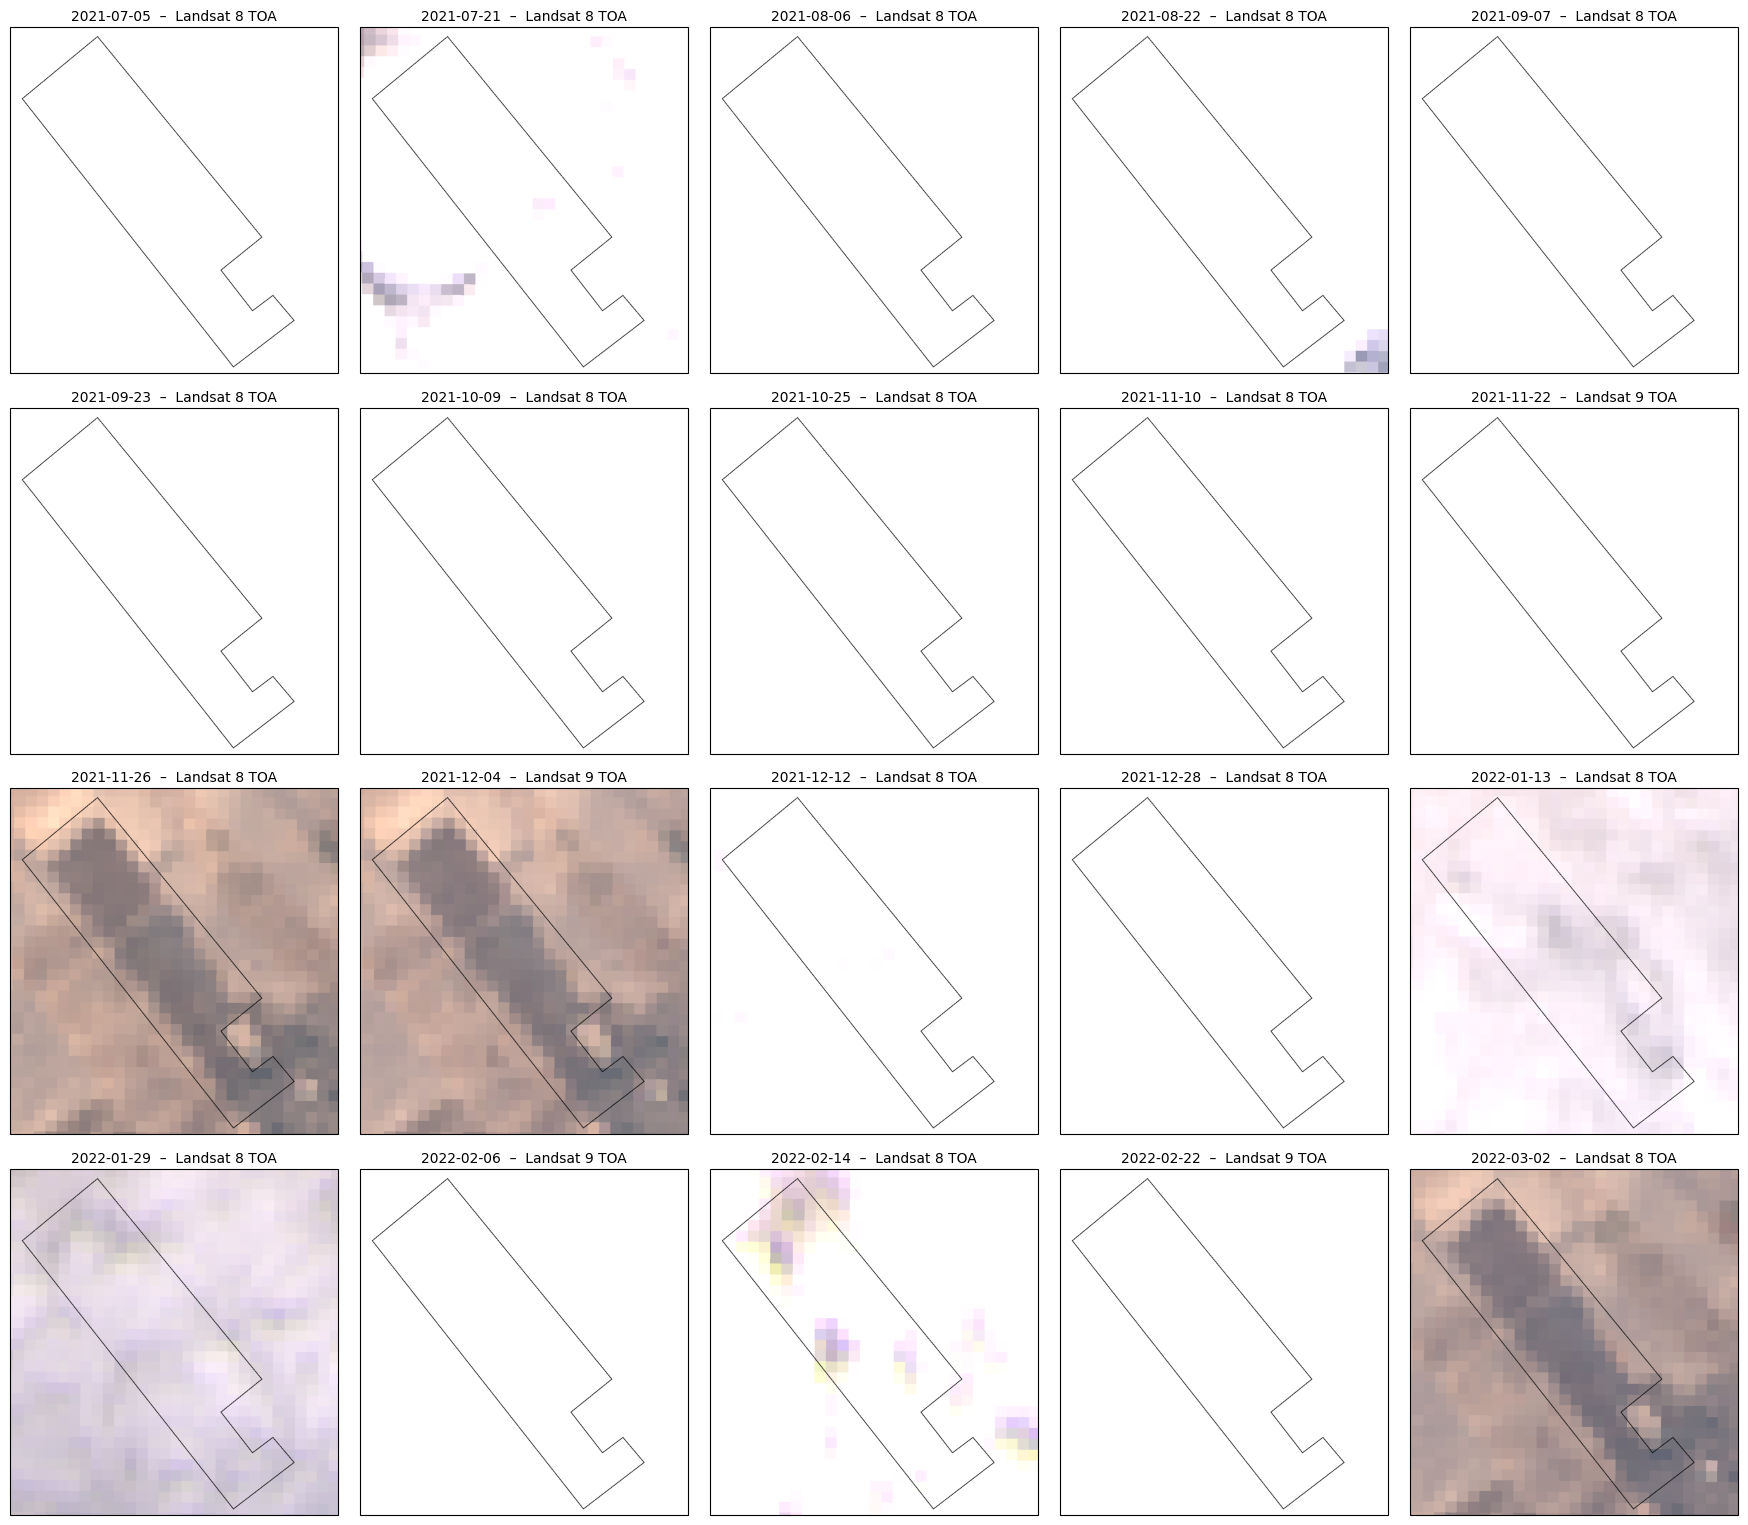

✅ Figura guardada: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\raw\Landsat_gallery_p02.png


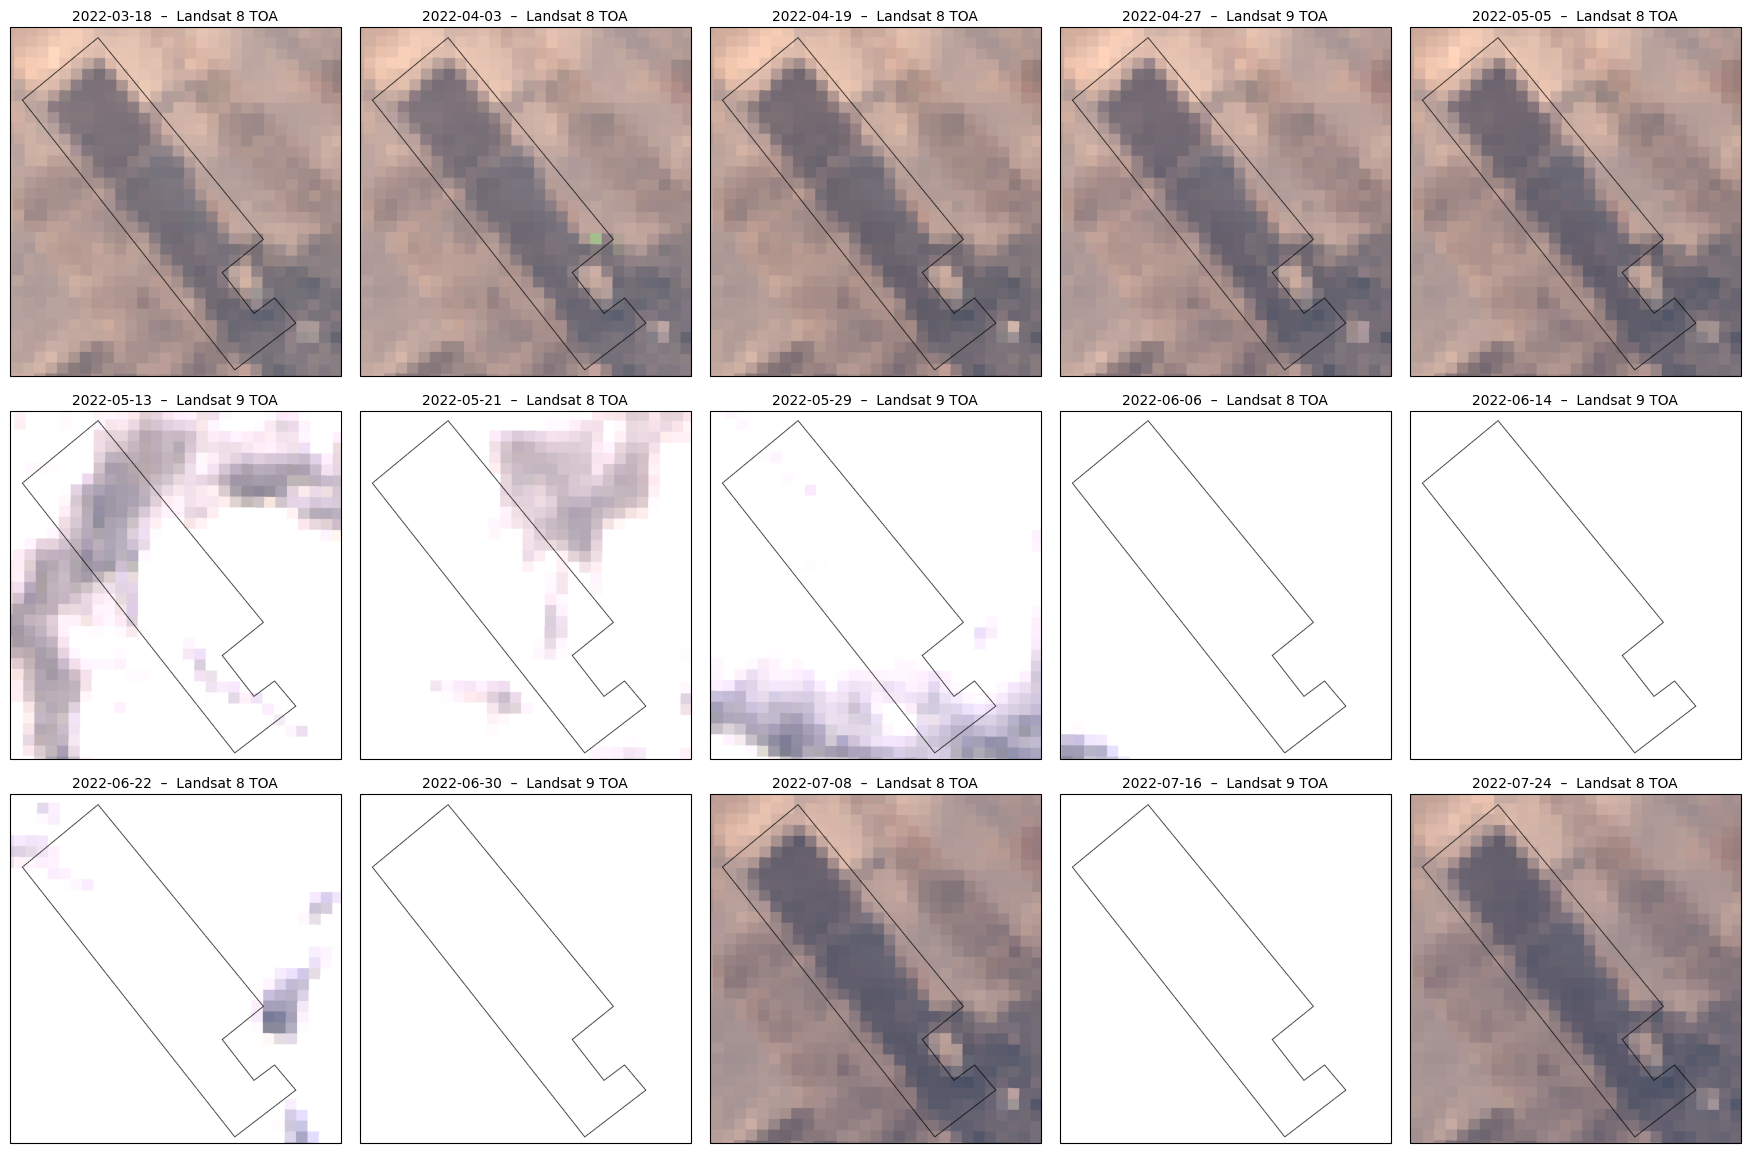

✅ 2 página(s) guardadas en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\raw


['C:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\figs\\preview\\raw\\Landsat_gallery_p01.png',
 'C:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\figs\\preview\\raw\\Landsat_gallery_p02.png']

In [16]:
# =========================
# IMPORTS Y ESTILO FIJO
# =========================
import math
from pathlib import Path

import ee
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

try:
    from geemap import cartoee as ce
except Exception:
    import cartoee as ce

ee.Initialize()

mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
})

# =========================
# PARÁMETROS BASE
# =========================
vis_rgb = {"bands": ["B4", "B3", "B2"], "min": 0.0, "max": 0.3, "gamma": 1.05}

extent = 0.0004
zoom_region = [
    -70.53539711730724 - extent,
    -18.185505011017327 - extent,
    -70.52796183246036 + extent,
    -18.177618129602468 + extent
]
dims = 1000

# ROI: si no existe una variable 'roi' previa, crea un rectángulo con zoom_region
try:
    roi  # noqa
except NameError:
    roi = ee.Geometry.Rectangle(zoom_region)

roi_outline = ee.Image().paint(roi, 1, 2).visualize(palette=["#000000"])

# =========================
# UTILIDADES
# =========================
def chunk(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

def landsat_num_from_id(img_id):
    # LC08_... o LANDSAT/LC08/...
    tail = img_id.split('/')[-1]
    return tail[2:4].lstrip('0')

def date_from_id(img_id):
    tail = img_id.split('/')[-1]
    ymd = tail.split('_')[-1]
    return f"{ymd[0:4]}-{ymd[4:6]}-{ymd[6:8]}"

def add_layer_compat(ax, ee_img, region, dims, vis_params=None):
    vis_params = vis_params or {}
    if hasattr(ce, "add_layer"):
        ce.add_layer(ax, ee_img, vis_params=vis_params, region=region, dims=dims)
    else:
        m = ce.get_map(ee_img, vis_params=vis_params, region=region, dims=dims)
        ax.imshow(m.get("image"))
        ax.set_extent(region, crs=ccrs.PlateCarree())

# =========================
# GALERÍA CONFIGURABLE
# =========================
def plot_all_ids(ids,
                 cols=5,
                 rows_per_page=4,
                 wspace=0.015,
                 hspace=0.12,
                 save_png=False,
                 prefix='galeria_L8L9',
                 title_fontsize=10.0):
    """
    Muestra las imágenes en páginas con 'cols' columnas y 'rows_per_page' filas.
    - wspace/hspace controlan separación entre columnas y filas.
    - Cambia 'cols' para 3, 4, 5, etc. según prefieras.
    Si save_png=True, guarda en la ruta fija de figs/preview/raw a 600 dpi.
    """
    if not ids:
        print("No hay IDs para graficar.")
        return []

    # Ruta fija solicitada
    save_dir = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\raw")
    if save_png:
        save_dir.mkdir(parents=True, exist_ok=True)

    per_page = cols * rows_per_page
    page_idx = 1
    saved_paths = []

    for page_ids in chunk(ids, per_page):
        n = len(page_ids)
        rows = math.ceil(n / cols)

        # Tamaño de figura proporcional
        fig_w = 4.0 * cols
        fig_h = 4.0 * rows
        fig = plt.figure(figsize=(fig_w, fig_h))

        gs = fig.add_gridspec(ncols=cols, nrows=rows, wspace=wspace, hspace=hspace)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        if rows == 1 and cols == 1:
            axs = [[axs]]
        elif rows == 1:
            axs = [axs]
        elif cols == 1:
            axs = [[ax] for ax in axs]

        # Márgenes de página
        plt.subplots_adjust(top=0.97, bottom=0.04, left=0.035, right=0.985)

        for i, img_id in enumerate(page_ids):
            r, c = divmod(i, cols)
            ax = axs[r][c]

            img = ee.Image(img_id)
            vis_img = img.visualize(**vis_rgb).blend(roi_outline)
            add_layer_compat(ax, vis_img, region=zoom_region, dims=dims, vis_params=None)

            sat = landsat_num_from_id(img_id)
            d   = date_from_id(img_id)
            ax.set_title(f"{d}  –  Landsat {sat} TOA", fontsize=title_fontsize, pad=5)

            ax.set_xticks([]); ax.set_yticks([])

        total_cells = rows * cols
        for j in range(n, total_cells):
            r, c = divmod(j, cols)
            axs[r][c].axis('off')

        if save_png:
            out = save_dir / f"{prefix}_p{page_idx:02d}.png"
            plt.savefig(out, dpi=600, bbox_inches="tight", pad_inches=0.1)
            print("✅ Figura guardada:", out)
            saved_paths.append(str(out))

        plt.show()
        page_idx += 1

    if save_png:
        print(f"✅ {len(saved_paths)} página(s) guardadas en: {save_dir}")
    return saved_paths

# =========================
# EJECUTAR CON TUS DATOS
# =========================
# Asegúrate de que df_l8_l9 existe y tiene la columna 'ID GEE'
ids = df_l8_l9['ID GEE'].tolist()

# Ejemplo: 5 columnas, 4 filas por página, separaciones compactas y guardado activado
plot_all_ids(
    ids,
    cols=5,
    rows_per_page=4,
    wspace=-0.3,
    hspace=0.10,
    save_png=True,
    prefix="Landsat_gallery"
)

# Otros ejemplos:
# plot_all_ids(ids, cols=5, rows_per_page=5, wspace=0.012, hspace=0.10, save_png=True, prefix="Landsat_gallery_5x5")
# plot_all_ids(ids, cols=3, rows_per_page=5, wspace=0.02,  hspace=0.12, save_png=True, prefix="Landsat_gallery_3x5")


In [12]:
# -*- coding: utf-8 -*-
"""
NDSI GLACIAR (2013 vs 2015) con Landsat 8 (C2 L2) – EXPORTACIÓN LOCAL
- Carga robusta de ROI (KML/SHP/GeoJSON/GPKG)
- NDSI y máscaras de glaciar, cambio 2013→2015
- Exporta localmente: GeoTIFF/PNG (rasters) y SHP (vectores)
"""

# =========================
# IMPORTS
# =========================
import os
import time
import ee
import geemap
import matplotlib.pyplot as plt
from geemap import cartoee as ce

# Geometría robusta
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely.ops import transform as shp_transform

# Para quitar Z con transform
from functools import partial
import pyproj

try:
    # Shapely >= 2.0
    from shapely.validation import make_valid as shp_make_valid
    HAS_MAKE_VALID = True
except Exception:
    HAS_MAKE_VALID = False

# =========================
# CONFIGURACIÓN DEL USUARIO
# =========================
VEC_PATH   = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\Pativilca.kml"
LOCAL_DIR  = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca"
FILE_PREFIX = "Pativilca"

# Rango (L8 desde 2013)
START_2013 = "2013-01-01"; END_2013 = "2013-12-31"
START_2015 = "2015-01-01"; END_2015 = "2015-12-31"

# Clasificador glaciar
NDSI_THR = 0.40
NDVI_MAX = 0.40

# Export params
SCALE_EXPORT = 30
MAXPIX       = 1_200_000_000

# Visualización opcional
VIS_NDSI = {'min': -0.5, 'max': 1.0,
            'palette': ['#1e3a8a', '#60a5fa', '#e5f2ff', '#fef3c7', '#f59e0b']}

# =========================
# EARTH ENGINE INIT
# =========================
# Si es la primera vez: ee.Authenticate()
ee.Initialize(project=None)

# =========================
# UTILIDADES GEOM
# =========================
def _force_2d(geom):
    if geom.is_empty:
        return geom
    def _drop_z(x, y, z=None): return (x, y)
    return shp_transform(_drop_z, geom)

def _clean_geom(geom):
    if geom.is_empty:
        return geom
    g = _force_2d(geom)
    if HAS_MAKE_VALID:
        try: g = shp_make_valid(g)
        except Exception: pass
    try: g = g.buffer(0)
    except Exception: pass
    return g

def _valid_lonlat_bounds(geom):
    try:
        minx, miny, maxx, maxy = geom.bounds
        return (minx >= -180 and maxx <= 180 and miny >= -90 and maxy <= 90)
    except Exception:
        return False

def load_roi_any(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".kml":
        gdf = gpd.read_file(path, driver="KML")
    elif ext in (".shp", ".geojson", ".json", ".gpkg"):
        gdf = gpd.read_file(path)
    else:
        raise ValueError(f"Formato no soportado: {ext}")
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)
    else:
        gdf = gdf.to_crs(epsg=4326)

    gdf = gdf.explode(index_parts=True, ignore_index=True)
    gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
    if len(gdf) == 0:
        raise RuntimeError("Vector vacío.")

    gdf["geometry"] = gdf["geometry"].apply(_clean_geom)
    gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()

    poly_mask = gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"])
    if poly_mask.any():
        gpoly = unary_union(gdf.loc[poly_mask, "geometry"].values)
        gpoly = _clean_geom(gpoly)
    else:
        gunion = unary_union(gdf.geometry.values)
        gunion = _clean_geom(gunion)
        if gunion.is_empty: raise RuntimeError("No hay geometrías para ROI.")
        gpoly = _clean_geom(gunion.convex_hull)

    if gpoly.is_empty or not _valid_lonlat_bounds(gpoly):
        raise RuntimeError("ROI inválido.")

    gdf_poly = gpd.GeoDataFrame(geometry=[gpoly], crs="EPSG:4326")
    fc = geemap.geopandas_to_ee(gdf_poly)
    roi = fc.geometry()
    return roi, fc

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

# =========================
# CARGA ROI
# =========================
roi, fc_vec = load_roi_any(VEC_PATH)
ensure_dir(LOCAL_DIR)

# =========================
# FUNCIONES EE (L8 C2 L2)
# =========================
REFL_SCALE  = 0.0000275
REFL_OFFSET = -0.2
QA_CLOUD_BIT, QA_CLOUD_SHADOW, QA_SNOW, QA_CIRRUS = 5, 3, 4, 7

def mask_l8_sr(img):
    qa = img.select('QA_PIXEL')
    def _bit(b): return qa.bitwiseAnd(1 << b).eq(0)
    mask = _bit(QA_CLOUD_BIT).And(_bit(QA_CLOUD_SHADOW)).And(_bit(QA_CIRRUS)).And(_bit(QA_SNOW))
    return img.updateMask(mask)

def scale_reflectance(img):
    refl = (img.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'])
              .multiply(REFL_SCALE).add(REFL_OFFSET)) \
              .copyProperties(img, img.propertyNames())
    return img.addBands(refl, overwrite=True)

def prep_l8_sr(col):
    return (col.map(mask_l8_sr)
               .map(scale_reflectance)
               .select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7','QA_PIXEL']))

def l8_sr_collection(start, end, geometry):
    col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
           .filterDate(start, end)
           .filterBounds(geometry))
    return prep_l8_sr(col)

def ndsi_from_l8(img):
    green = img.select('SR_B3'); swir1 = img.select('SR_B6')
    ndsi = green.subtract(swir1).divide(green.add(swir1)).rename('NDSI')
    return img.addBands(ndsi)

def ndvi_from_l8(img):
    nir = img.select('SR_B5'); red = img.select('SR_B4')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return img.addBands(ndvi)

def composite_ndsi(col):
    col2 = col.map(ndsi_from_l8).map(ndvi_from_l8)
    return col2.median()

def glacier_mask(img, ndsi_thr=NDSI_THR, ndvi_max=NDVI_MAX):
    ndsi_bin = img.select('NDSI').gte(ndsi_thr)
    ndvi_bin = img.select('NDVI').lt(ndvi_max)
    clean = img.select(['SR_B3','SR_B6']).reduce(ee.Reducer.min()).gt(0)
    return ndsi_bin.And(ndvi_bin).And(clean).rename('GLACIER')

def vectors_from_mask(mask_img, region, scale=SCALE_EXPORT, label='class'):
    return mask_img.selfMask().rename('mask').reduceToVectors(
        geometry=region,
        crs=mask_img.projection(),
        scale=scale,
        labelProperty=label,
        geometryType='polygon',
        maxPixels=MAXPIX
    )

def add_area_fields(fc_poly):
    def _f(ft):
        g = ft.geometry()
        a_m2 = g.area(maxError=1)
        return ft.set({'area_m2': a_m2, 'area_ha': a_m2.divide(10_000.0)})
    return fc_poly.map(_f)

# =========================
# DATOS (2013 y 2015)
# =========================
col2013 = l8_sr_collection(START_2013, END_2013, roi)
col2015 = l8_sr_collection(START_2015, END_2015, roi)

if col2013.size().getInfo() == 0: raise RuntimeError("Sin escenas 2013 en ROI.")
if col2015.size().getInfo() == 0: raise RuntimeError("Sin escenas 2015 en ROI.")

comp2013 = composite_ndsi(col2013).clip(roi)
comp2015 = composite_ndsi(col2015).clip(roi)

g2013 = glacier_mask(comp2013)
g2015 = glacier_mask(comp2015)

perdida  = g2013.And(g2015.Not()).rename('LOSS')
ganancia = g2015.And(g2013.Not()).rename('GAIN')

vec2013  = add_area_fields(vectors_from_mask(g2013, roi)).map(lambda f: f.set({'year': 2013}))
vec2015  = add_area_fields(vectors_from_mask(g2015, roi)).map(lambda f: f.set({'year': 2015}))
vec_loss = add_area_fields(vectors_from_mask(perdida, roi)).map(lambda f: f.set({'change': 'loss_2013_to_2015'}))
vec_gain = add_area_fields(vectors_from_mask(ganancia, roi)).map(lambda f: f.set({'change': 'gain_2013_to_2015'}))

def total_area_ha(fc): return ee.Number(fc.aggregate_sum('area_ha'))
print('--- ÁREAS TOTALES (ha) ---')
print('Glaciar 2013:', total_area_ha(vec2013).getInfo())
print('Glaciar 2015:', total_area_ha(vec2015).getInfo())
print('Pérdida 13→15:', total_area_ha(vec_loss).getInfo())
print('Ganancia 13→15:', total_area_ha(vec_gain).getInfo())

# =========================
# EXPORTACIÓN LOCAL
# =========================
def export_local_image(img, filepath_tif, region, scale=SCALE_EXPORT, vis=None, also_png=False):
    # GeoTIFF
    geemap.ee_export_image(
        img,                      # <-- sin image=
        filename=filepath_tif,
        scale=scale,
        region=region
    )
    print(f"✅ Guardado GeoTIFF: {filepath_tif}")

    # PNG opcional
    if also_png:
        png_path = os.path.splitext(filepath_tif)[0] + ".png"
        vis_img = img.visualize(**(vis or {'min': -1, 'max': 1, 'palette': ['0000ff', 'ffffff', 'ff0000']}))
        geemap.ee_export_image(
            vis_img,              # <-- sin image=
            filename=png_path,
            scale=scale,
            region=region
        )
        print(f"✅ Guardado PNG: {png_path}")

def export_local_vector(fc, filepath_shp):
    geemap.ee_export_vector(fc, filename=filepath_shp)
    print(f"✅ Guardado SHP: {filepath_shp}")

out = ensure_dir(LOCAL_DIR)

# Rasters (GeoTIFF + PNG)
export_local_image(comp2013.select('NDSI'), os.path.join(out, f"{FILE_PREFIX}_NDSI_2013.tif"),
                   region=roi, scale=SCALE_EXPORT, vis=VIS_NDSI, also_png=True)
export_local_image(comp2015.select('NDSI'), os.path.join(out, f"{FILE_PREFIX}_NDSI_2015.tif"),
                   region=roi, scale=SCALE_EXPORT, vis=VIS_NDSI, also_png=True)
export_local_image(g2013, os.path.join(out, f"{FILE_PREFIX}_GLACIER_2013.tif"),
                   region=roi, scale=SCALE_EXPORT)
export_local_image(g2015, os.path.join(out, f"{FILE_PREFIX}_GLACIER_2015.tif"),
                   region=roi, scale=SCALE_EXPORT)
export_local_image(perdida, os.path.join(out, f"{FILE_PREFIX}_LOSS_2013_2015.tif"),
                   region=roi, scale=SCALE_EXPORT)
export_local_image(ganancia, os.path.join(out, f"{FILE_PREFIX}_GAIN_2013_2015.tif"),
                   region=roi, scale=SCALE_EXPORT)

# Vectores (SHP: carpeta con .shp/.dbf/.shx/.prj)
export_local_vector(vec2013,  os.path.join(out, f"{FILE_PREFIX}_GLACIAR_2013.shp"))
export_local_vector(vec2015,  os.path.join(out, f"{FILE_PREFIX}_GLACIAR_2015.shp"))
export_local_vector(vec_loss, os.path.join(out, f"{FILE_PREFIX}_PERDIDA_2013_2015.shp"))
export_local_vector(vec_gain, os.path.join(out, f"{FILE_PREFIX}_GANANCIA_2013_2015.shp"))

print("\n✅ Exportación LOCAL completada en:", out)

# =========================
# PREVISUALIZACIÓN ESTÁTICA (opcional)
# =========================
try:
    region_poly = roi.bounds().getInfo()['coordinates'][0]
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes([0.05, 0.05, 0.9, 0.9])
    ce.add_layer(ax, comp2015.select('NDSI'), vis_params=VIS_NDSI, region=region_poly, dims=1200)
    outline = ee.Image().paint(roi, 1, 2).visualize(palette=['#000000'])
    ce.add_layer(ax, outline, region=region_poly, dims=1200)
    ax.set_axis_off()
    preview_path = os.path.join(out, f"{FILE_PREFIX}_preview_2015.png")
    plt.savefig(preview_path, dpi=300, bbox_inches="tight")
    print(f"🖼️  Preview guardado en: {preview_path}")
except Exception as e:
    print("No se generó la previsualización estática. Detalle:", repr(e))


--- ÁREAS TOTALES (ha) ---
Glaciar 2013: 0.08832533163481349
Glaciar 2015: 0.7949112832347761
Pérdida 13→15: 0
Ganancia 13→15: 0
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca\Pativilca_NDSI_2013.tif
✅ Guardado GeoTIFF: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca\Pativilca_NDSI_2013.tif
The filename must end with .tif
✅ Guardado PNG: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca\Pativilca_NDSI_2013.png
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca\Pativilca_NDSI_2015.tif
✅ Guardado GeoTIFF: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\outputs\ndsi_pativilca\Pativilca_NDSI_2015.tif
The filename must end with .tif
✅ Guardado PNG: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\ou

EEException: Element.propertyNames: Parameter 'element' is required and may not be null.

✅ Figura guardada: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\clean\Landsat_gallery_clean_p01.png


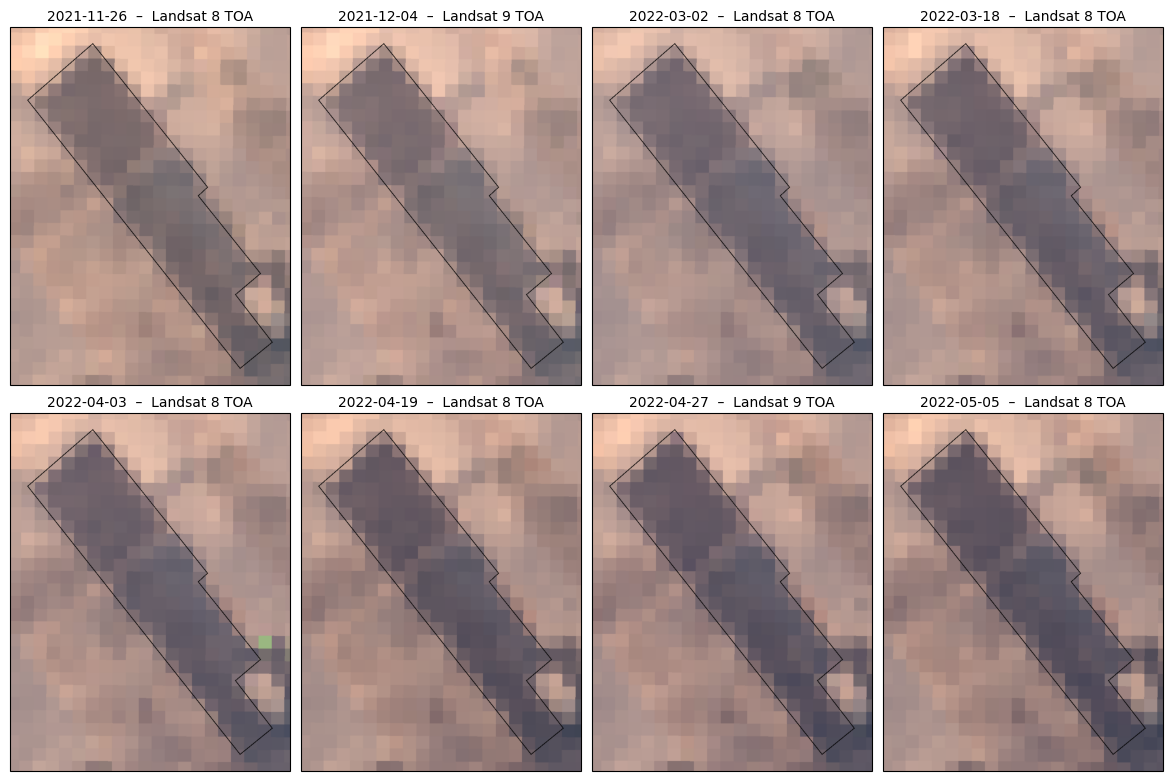

✅ 1 página(s) guardadas en: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\clean


['C:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\figs\\preview\\clean\\Landsat_gallery_clean_p01.png']

In [ ]:
# =========================
# IMPORTS Y ESTILO FIJO
# =========================
import math
from pathlib import Path

import ee
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

try:
    from geemap import cartoee as ce
except Exception:
    import cartoee as ce

ee.Initialize()

mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
})

# =========================
# ROI (tu asset) + ZOOM REGION DESDE ROI
# =========================
# roi_fc = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')
roi_fc = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive')
roi = roi_fc.geometry()

# BBox del ROI con margen y conversión correcta a listas de EE
margin_m = 40
rect = roi.buffer(margin_m).bounds(1)
coords = ee.List(rect.coordinates().get(0))
ws = ee.List(coords.get(0))
en = ee.List(coords.get(2))
zoom_region = [
    ee.Number(ws.get(0)).getInfo(),
    ee.Number(ws.get(1)).getInfo(),
    ee.Number(en.get(0)).getInfo(),
    ee.Number(en.get(1)).getInfo(),
]
dims = 1000

# Borde del ROI pintado en negro (ancho 2 px)
roi_outline = ee.Image().paint(roi_fc, 1, 2).visualize(palette=['#000000'], opacity=1.0)

# =========================
# PARÁMETROS VISUALES
# =========================
vis_rgb = {"bands": ["B4","B3","B2"], "min": 0.03, "max": 0.30, "gamma": 1.05}

# =========================
# UTILIDADES
# =========================
def chunk(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

def landsat_num_from_id(img_id):
    tail = img_id.split('/')[-1]
    return tail[2:4].lstrip('0') or tail[2:4]

def date_from_id(img_id):
    tail = img_id.split('/')[-1]
    ymd = tail.split('_')[-1]
    return f"{ymd[0:4]}-{ymd[4:6]}-{ymd[6:8]}"

def add_layer_compat(ax, ee_img, region, dims, vis_params=None):
    vis_params = vis_params or {}
    if hasattr(ce, "add_layer"):
        ce.add_layer(ax, ee_img, vis_params=vis_params, region=region, dims=dims)
    else:
        m = ce.get_map(ee_img, vis_params=vis_params, region=region, dims=dims)
        ax.imshow(m.get("image"))
        ax.set_extent(region, crs=ccrs.PlateCarree())

# =========================
# GALERÍA
# =========================
def plot_all_ids(ids,
                 cols=5,
                 rows_per_page=4,
                 wspace=0.015,
                 hspace=0.12,
                 save_png=False,
                 prefix='galeria_L8L9',
                 title_fontsize=10.0):
    if not ids:
        print("No hay IDs para graficar.")
        return []

    # --- Carpeta CLEAN solicitada ---
    save_dir = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\clean")
    if save_png:
        save_dir.mkdir(parents=True, exist_ok=True)

    per_page = cols * rows_per_page
    page_idx = 1
    saved_paths = []

    for page_ids in chunk(ids, per_page):
        n = len(page_ids)
        rows = math.ceil(n / cols)

        fig_w = 4.0 * cols
        fig_h = 4.0 * rows
        fig = plt.figure(figsize=(fig_w, fig_h))

        gs = fig.add_gridspec(ncols=cols, nrows=rows, wspace=wspace, hspace=hspace)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        if rows == 1 and cols == 1:
            axs = [[axs]]
        elif rows == 1:
            axs = [axs]
        elif cols == 1:
            axs = [[ax] for ax in axs]

        plt.subplots_adjust(top=0.97, bottom=0.04, left=0.035, right=0.985)

        for i, img_id in enumerate(page_ids):
            r, c = divmod(i, cols)
            ax = axs[r][c]

            img = ee.Image(img_id)
            vis_img = img.visualize(**vis_rgb).blend(roi_outline)
            add_layer_compat(ax, vis_img, region=zoom_region, dims=dims, vis_params=None)

            sat = landsat_num_from_id(img_id)
            d   = date_from_id(img_id)
            ax.set_title(f"{d}  –  Landsat {sat} TOA", fontsize=title_fontsize, pad=5)

            ax.set_xticks([]); ax.set_yticks([])

        total_cells = rows * cols
        for j in range(n, total_cells):
            r, c = divmod(j, cols)
            axs[r][c].axis('off')

        if save_png:
            out = save_dir / f"{prefix}_p{page_idx:02d}.png"
            plt.savefig(out, dpi=600, bbox_inches="tight", pad_inches=0.1)
            print("✅ Figura guardada:", out)
            saved_paths.append(str(out))

        plt.show()
        page_idx += 1

    if save_png:
        print(f"✅ {len(saved_paths)} página(s) guardadas en: {save_dir}")
    return saved_paths

# =========================
# IDS TOA A GRAFICAR (limpias/sin nubes)
# =========================
lista_ids = [
    
    # 'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1_TOA/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220505',
    # 'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220708',
    # 'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220724',
]

# =========================
# GRAFICAR Y GUARDAR EN CLEAN
# =========================
plot_all_ids(
    lista_ids,
    cols=4,
    rows_per_page=4,
    wspace=-0.55,
    hspace=0.08,
    save_png=True,                 # <- ACTIVADO
    prefix="Landsat_gallery_clean" # <- prefijo para distinguir
)


KeyboardInterrupt: 

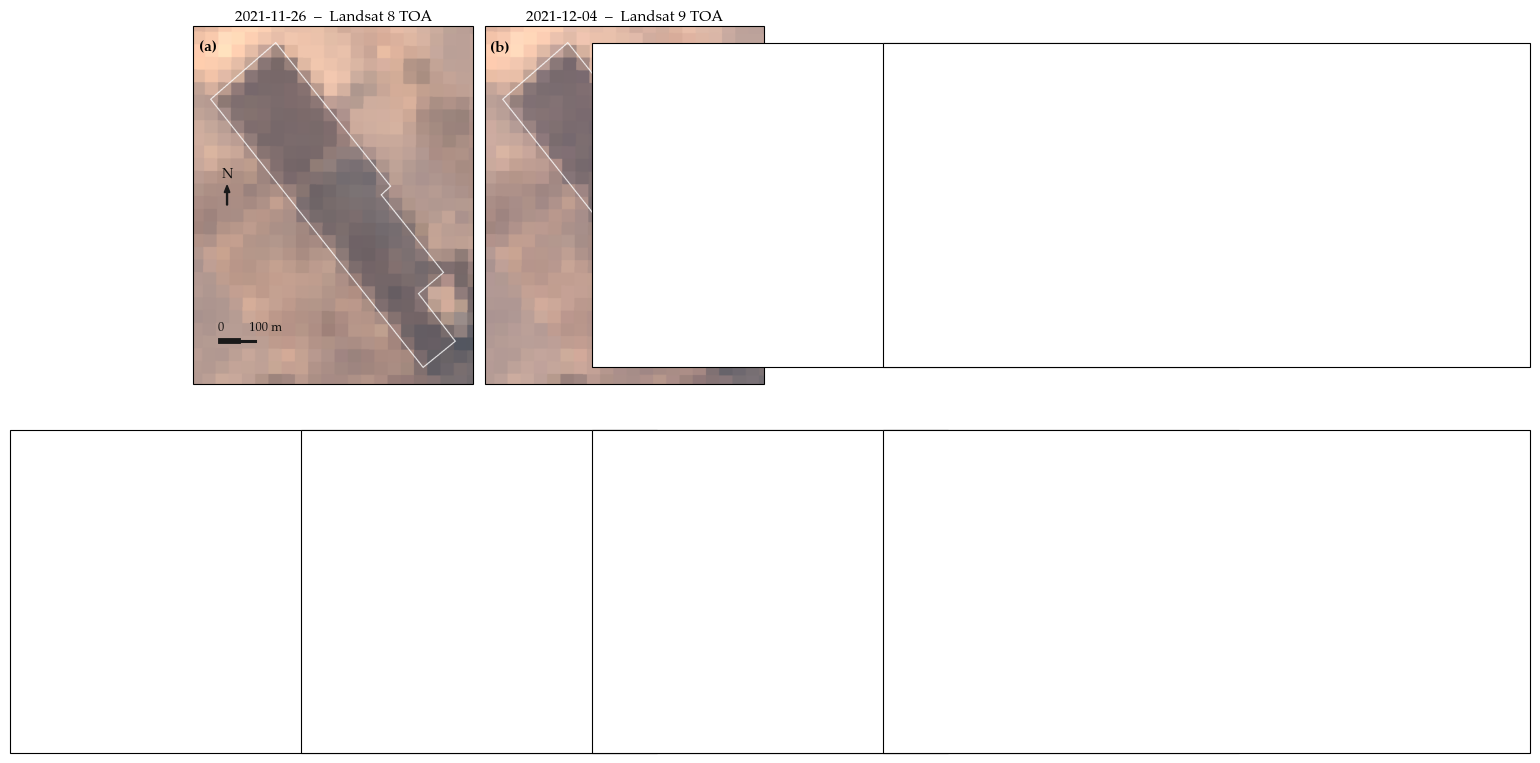

In [20]:
# =========================
# IMPORTS Y ESTILO FIJO
# =========================
import math
from pathlib import Path

import ee
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

try:
    from geemap import cartoee as ce
except Exception:
    import cartoee as ce

ee.Initialize()

mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Palatino","TeX Gyre Pagella","Times New Roman"]
})

# =========================
# ROI (tu asset) + ZOOM REGION DESDE ROI
# =========================
# roi_fc = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')
roi_fc = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive')
roi = roi_fc.geometry()

# BBox del ROI con margen y conversión correcta a listas de EE
margin_m = 40
rect = roi.buffer(margin_m).bounds(1)
coords = ee.List(rect.coordinates().get(0))
ws = ee.List(coords.get(0))
en = ee.List(coords.get(2))
zoom_region = [
    ee.Number(ws.get(0)).getInfo(),
    ee.Number(ws.get(1)).getInfo(),
    ee.Number(en.get(0)).getInfo(),
    ee.Number(en.get(1)).getInfo(),
]
dims = 1000

# ===== ROI outline en blanco elegante =====
roi_outline = ee.Image().paint(roi_fc, 1, 3).visualize(palette=['#ffffff'], opacity=0.9)

# =========================
# PARÁMETROS VISUALES
# =========================
vis_rgb = {"bands": ["B4","B3","B2"], "min": 0.03, "max": 0.30, "gamma": 1.05}

# =========================
# UTILIDADES
# =========================
def chunk(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i+size]

def landsat_num_from_id(img_id):
    tail = img_id.split('/')[-1]
    return tail[2:4].lstrip('0') or tail[2:4]

def date_from_id(img_id):
    tail = img_id.split('/')[-1]
    ymd = tail.split('_')[-1]
    return f"{ymd[0:4]}-{ymd[4:6]}-{ymd[6:8]}"

def add_layer_compat(ax, ee_img, region, dims, vis_params=None):
    vis_params = vis_params or {}
    if hasattr(ce, "add_layer"):
        ce.add_layer(ax, ee_img, vis_params=vis_params, region=region, dims=dims)
    else:
        m = ce.get_map(ee_img, vis_params=vis_params, region=region, dims=dims)
        ax.imshow(m.get("image"))
        ax.set_extent(region, crs=ccrs.PlateCarree())

# =========================
# 🧭 NORTH & SCALE (sin fondos que tapen el raster)
# =========================
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12, txt="0        100 m"):
    """
    Barra visual de 100 m dibujada en coordenadas de ejes (estilo Q1 minimalista).
    - loc: (x,y) en coords de ejes [0..1]
    - width_axes: fracción del ancho del eje para el segmento principal
    """
    trans = ax.transAxes
    x0, y0 = loc
    L = width_axes
    # tramo base
    ax.plot([x0, x0 + L], [y0, y0], transform=trans, lw=2.2, color='0.1', zorder=2)
    # tramo izquierdo resaltado (mitad)
    ax.plot([x0, x0 + L/2], [y0, y0], transform=trans, lw=4.2, color='0.1', zorder=2)
    # texto
    ax.text(x0-0.014, y0 + 0.018, txt, transform=trans, fontsize=9,
            va='bottom', ha='left', color='0.05', zorder=2)

def north_arrow(ax, loc=(0.12, 0.50)):
    """
    Flecha de Norte minimalista en coords de ejes (estilo Q1).
    """
    x, y = loc
    trans = ax.transAxes
    ax.arrow(x, y, 0, 0.055, transform=trans,
             width=0.0035, head_width=0.02, head_length=0.02,
             color='0.1', length_includes_head=True, zorder=2)
    ax.text(x, y + 0.065, 'N', transform=trans, ha='center', va='bottom',
            fontsize=10, color='0.05', zorder=2)

# =========================
# GALERÍA
# =========================
def plot_all_ids(ids,
                 cols=5,
                 rows_per_page=4,
                 wspace=0.015,
                 hspace=0.12,
                 save_png=False,
                 prefix='galeria_L8L9',
                 title_fontsize=9.0,
                 label_paneles=True,
                 label_fontsize=11,          # <-- tamaño de letras (a–h)
                 label_pos=(0.02, 0.96),     # <-- posición (x,y) en coords de ejes
                 put_north_and_scale=True    # <-- dibujar N y escala en (a)
                 ):
    if not ids:
        print("No hay IDs para graficar.")
        return []

    # --- Carpeta CLEAN solicitada ---
    save_dir = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\preview\clean")
    if save_png:
        save_dir.mkdir(parents=True, exist_ok=True)

    per_page = cols * rows_per_page
    page_idx = 1
    saved_paths = []

    for page_ids in chunk(ids, per_page):
        n = len(page_ids)
        rows = math.ceil(n / cols)

        fig_w = 4.0 * cols
        fig_h = 4.0 * rows
        fig = plt.figure(figsize=(fig_w, fig_h))

        gs = fig.add_gridspec(ncols=cols, nrows=rows, wspace=wspace, hspace=hspace)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        if rows == 1 and cols == 1:
            axs = [[axs]]
        elif rows == 1:
            axs = [axs]
        elif cols == 1:
            axs = [[ax] for ax in axs]

        plt.subplots_adjust(top=0.97, bottom=0.04, left=0.035, right=0.985)

        for i, img_id in enumerate(page_ids):
            r, c = divmod(i, cols)
            ax = axs[r][c]

            img = ee.Image(img_id)
            vis_img = img.visualize(**vis_rgb).blend(roi_outline)
            add_layer_compat(ax, vis_img, region=zoom_region, dims=dims, vis_params=None)

            sat = landsat_num_from_id(img_id)
            d   = date_from_id(img_id)
            ax.set_title(f"{d}  –  Landsat {sat} TOA", fontsize=title_fontsize, pad=4)

            # ===== Etiquetas (a)–(h) =====
            if label_paneles:
                ax.text(label_pos[0], label_pos[1], f"({chr(97 + i)})",
                        transform=ax.transAxes,
                        fontsize=label_fontsize, fontweight='bold', color='black',
                        va='top', ha='left')

            # Solo en el primer panel de cada página: Norte + Escala
            if put_north_and_scale and i == 0:
                scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12)
                north_arrow(ax, loc=(0.12, 0.50))

            ax.set_xticks([]); ax.set_yticks([])

        # Ocultar celdas vacías
        total_cells = rows * cols
        for j in range(n, total_cells):
            r, c = divmod(j, cols)
            axs[r][c].axis('off')

        if save_png:
            out = save_dir / f"{prefix}_p{page_idx:02d}.png"
            plt.savefig(out, dpi=600, bbox_inches="tight", pad_inches=0.1)
            print("✅ Figura guardada:", out)
            saved_paths.append(str(out))

        plt.show()
        page_idx += 1

    if save_png:
        print(f"✅ {len(saved_paths)} página(s) guardadas en: {save_dir}")
    return saved_paths

# =========================
# IDS TOA A GRAFICAR (limpias/sin nubes)
# =========================
lista_ids = [
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1_TOA/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1_TOA/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220505',
    # 'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220708',
    # 'LANDSAT/LC08/C02/T1_TOA/LC08_002073_20220724',
]

# =========================
# GRAFICAR Y GUARDAR EN CLEAN
# =========================
plot_all_ids(
    lista_ids,
    cols=4,
    rows_per_page=4,
    wspace=-0.55,
    hspace=0.08,
    save_png=True,                  # <- ACTIVADO
    prefix="Landsat_gallery_clean", # <- prefijo para distinguir
    label_paneles=True,             # <- añade (a)–(h)
    label_fontsize=11,              # <- un poco más grande (como pediste)
    label_pos=(0.02, 0.96),         # <- un poco más arriba
    put_north_and_scale=True,        # <- agrega N y escala en (a)
    title_fontsize=11  # 🔹 Aumenta el tamaño de los títulos
)



In [10]:
# -*- coding: utf-8 -*-
"""
Tabla Q1 (METRIC) con % de nubosidad EN EL ROI usando QA_PIXEL (Landsat C2 L2)
- Entrada: 8 escenas dadas como LANDSAT/LC0X/C02/T1/LC0X_...
- Se busca el equivalente T1_L2 (SR+ST) y se calcula % nube EN EL ROI.
- Hora local Perú (UTC-5).
- Salida: CSV + LaTeX con columnas:
  Data, Year, Product Identifier, Sensing Time (UTC-5), Cloud Cover %, Zone
"""

import re
from pathlib import Path
from datetime import datetime, timedelta

import ee
import pandas as pd

# =========================
# ⚙️ Configuración
# =========================
# Modo de nubosidad dentro del ROI:
#  - "expanded": cuenta Cloud (bit3), Cirrus (bit2), Cloud Shadow (bit4) y Dilated Cloud (bit1)
#  - "strict":   cuenta solo Cloud (bit3)
CLOUD_MODE = "expanded"   # ← Cambia a "strict" si deseas solo nube estricta
INCLUDE_SNOW = False      # True para incluir nieve (bit5) si aplica

# Salida
out_dir = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\tables")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path_paper = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_paper.csv"
tex_path_paper = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_paper.tex"

# =========================
# EE init
# =========================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# =========================
# ROI y colecciones
# =========================
ROI_ASSET = 'projects/ee-joluhumu/assets/Olive'
roi_fc = ee.FeatureCollection(ROI_ASSET)
roi = roi_fc.geometry()
ZONE_NAME = "Olive (Tacna)"

COL_L8_L2 = 'LANDSAT/LC08/C02/T1_L2'
COL_L9_L2 = 'LANDSAT/LC09/C02/T1_L2'

# Tus 8 escenas (T1) para buscar equivalentes L2
lista_ids_toa = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505'
]

# =========================
# Utilidades
# =========================
pat = re.compile(r'(LC0[89])_(\d{3})(\d{3})_(\d{8})')

def parse_tail(asset_id: str):
    """Devuelve (sensor, path, row, yyyymmdd) del tail LC0X_PPPQQQ_YYYYMMDD."""
    tail = asset_id.split('/')[-1]
    m = pat.match(tail)
    if not m:
        raise ValueError(f"ID inesperado: {asset_id}")
    sensor, path, row, ymd = m.groups()
    return sensor, int(path), int(row), ymd

def find_l2_equivalent(t1_id: str) -> str:
    """Encuentra el L2 equivalente (misma fecha ±1 día, path/row, misión)."""
    sensor, path, row, ymd = parse_tail(t1_id)
    dt = datetime.strptime(ymd, "%Y%m%d")

    start = ee.Date((dt - timedelta(days=1)).strftime("%Y-%m-%d"))
    end   = ee.Date((dt + timedelta(days=1)).strftime("%Y-%m-%d"))

    col_id = COL_L8_L2 if sensor == 'LC08' else COL_L9_L2
    col = (ee.ImageCollection(col_id)
           .filterDate(start, end.advance(1, 'day'))
           .filter(ee.Filter.eq('WRS_PATH', path))
           .filter(ee.Filter.eq('WRS_ROW', row))
           .filterBounds(roi)
           .filter(ee.Filter.eq('SENSOR_ID', 'OLI_TIRS')))

    ids = col.aggregate_array('system:id').getInfo() or []
    if not ids:
        # Fallback sin bounds (por si el footprint no cae completamente sobre el ROI)
        col2 = (ee.ImageCollection(col_id)
                .filterDate(start, end.advance(1, 'day'))
                .filter(ee.Filter.eq('WRS_PATH', path))
                .filter(ee.Filter.eq('WRS_ROW', row))
                .filter(ee.Filter.eq('SENSOR_ID', 'OLI_TIRS')))
        ids = col2.aggregate_array('system:id').getInfo() or []

    if not ids:
        raise RuntimeError(f"No se encontró L2 equivalente para {t1_id}")

    # Elegir la más cercana temporalmente
    def millis(img_id):
        return ee.Number(ee.Image(img_id).date().millis()).getInfo()
    ids_sorted = sorted(ids, key=millis)
    return ids_sorted[0]

def roi_cloud_percent_from_qapixel(img: ee.Image, geometry: ee.Geometry) -> float:
    """
    Calcula % de nube EN EL ROI usando QA_PIXEL (C2 L2).
    Bits usados:
      bit1: Dilated cloud
      bit2: Cirrus
      bit3: Cloud
      bit4: Cloud shadow
      bit5: Snow (opcional)
    """
    qa = img.select('QA_PIXEL')

    def bit(b):
        return qa.bitwiseAnd(1 << b).neq(0)

    if CLOUD_MODE.lower() == "strict":
        cloudish = bit(3)  # solo Cloud
    else:
        # expandido: Cloud OR Cirrus OR Shadow OR Dilated Cloud
        cloudish = bit(3).Or(bit(2)).Or(bit(4)).Or(bit(1))

    if INCLUDE_SNOW:
        cloudish = cloudish.Or(bit(5))

    # Área de píxel a 30 m
    area = ee.Image.pixelArea()

    # Total válido: usa máscara de reflectancia (ej. SR_B3)
    valid_mask = img.select('SR_B3').mask()

    # Sumar área nublada y total en el ROI
    cloud_area = area.updateMask(cloudish).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,
        maxPixels=1e10,
        tileScale=4
    ).get('area')

    total_area = area.updateMask(valid_mask).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,
        maxPixels=1e10,
        tileScale=4
    ).get('area')

    cloud_area = (cloud_area.getInfo() or 0.0)
    total_area = (total_area.getInfo() or 0.0)
    pct = round(100.0 * cloud_area / total_area, 2) if total_area > 0 else 0.0
    return pct

def build_row_from_l2(l2_id: str) -> dict:
    """Fila con metadatos + % nube EN ROI y hora local (UTC-5)."""
    img = ee.Image(l2_id)

    # Fecha/hora
    millis = ee.Number(img.date().millis()).getInfo()
    date_utc = datetime.utcfromtimestamp(millis/1000)
    local = date_utc - timedelta(hours=5)  # Perú UTC-5

    # Product Identifier
    product_id = ee.String(img.get('LANDSAT_PRODUCT_ID')).getInfo()
    if not product_id:
        product_id = ee.String(img.get('SYSTEM_INDEX')).getInfo() or l2_id.split('/')[-1]

    spacecraft = (ee.String(img.get('SPACECRAFT_ID')).getInfo() or '')

    # % nubes EN ROI
    roi_cloud_pct = roi_cloud_percent_from_qapixel(img, roi)

    return {
        "Data": "Landsat 9" if "LANDSAT_9" in spacecraft else "Landsat 8",
        "Year": local.year,
        "Product Identifier": product_id,
        "Sensing Time (UTC-5)": local.strftime("%H:%M:%S"),
        "Cloud Cover %": roi_cloud_pct,  # ahora corresponde al ROI
        "Zone": ZONE_NAME,
        "Fecha": local.strftime("%Y-%m-%d"),  # solo para ordenar
    }

# =========================
# Ejecutar flujo
# =========================
l2_ids = [find_l2_equivalent(tid) for tid in lista_ids_toa]
rows   = [build_row_from_l2(i) for i in l2_ids]
df_all = (pd.DataFrame(rows)
            .sort_values("Fecha")
            .reset_index(drop=True))

# Tabla final (paper)
cols_paper = ["Data", "Year", "Product Identifier",
              "Sensing Time (UTC-5)", "Cloud Cover %", "Zone"]
df_paper = df_all[cols_paper]

# Exportar
df_paper.to_csv(csv_path_paper, index=False)
with open(tex_path_paper, "w", encoding="utf-8") as f:
    f.write(df_paper.to_latex(index=False,
                              column_format="l l l l r l",
                              longtable=False,
                              escape=True))

print("Tabla (paper):")
print(df_paper)
print(f"\n✅ CSV (paper): {csv_path_paper}")
print(f"✅ LaTeX (paper): {tex_path_paper}")


C:\Users\joluh\AppData\Local\Temp\ipykernel_35852\2583534947.py:172: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date_utc = datetime.utcfromtimestamp(millis/1000)


Tabla (paper):
        Data  Year                        Product Identifier  \
0  Landsat 8  2021  LC08_L2SP_002073_20211126_20211201_02_T1   
1  Landsat 9  2021  LC09_L2SP_002073_20211204_20230505_02_T1   
2  Landsat 8  2022  LC08_L2SP_002073_20220302_20220309_02_T1   
3  Landsat 8  2022  LC08_L2SP_002073_20220318_20220322_02_T1   
4  Landsat 8  2022  LC08_L2SP_002073_20220403_20220412_02_T1   
5  Landsat 8  2022  LC08_L2SP_002073_20220419_20220427_02_T1   
6  Landsat 9  2022  LC09_L2SP_002073_20220427_20230418_02_T1   
7  Landsat 8  2022  LC08_L2SP_002073_20220505_20220512_02_T1   

  Sensing Time (UTC-5)  Cloud Cover %           Zone  
0             09:42:24            0.0  Olive (Tacna)  
1             09:42:27            0.0  Olive (Tacna)  
2             09:42:03            0.0  Olive (Tacna)  
3             09:41:56            0.0  Olive (Tacna)  
4             09:41:47            0.0  Olive (Tacna)  
5             09:41:52            0.0  Olive (Tacna)  
6             09:41:47 

In [12]:
# -*- coding: utf-8 -*-
"""
Tabla Q1 (METRIC) con % de nubosidad EN EL ROI usando QA_PIXEL (Landsat C2 L2)
- Encuentra el equivalente L2 (SR+ST) de una lista de escenas T1 (TOA) dadas.
- Calcula % de nube EN EL ROI (QA_PIXEL) y exporta tablas:
   (a) PAPER  : Sensor, Date, DOY, Overpass (UTC-5), Path/Row, Product ID (corto), Cloud % (ROI)
   (b) SUPPL  : + Product Identifier completo y Zone
- Guarda CSV en UTF-8 con BOM (utf-8-sig) para evitar "â…" en Excel.
- Pensado para Perú (UTC-5).
"""

import re
from pathlib import Path
from datetime import datetime, timedelta

import ee
import pandas as pd

# =========================
# ⚙️ Configuración
# =========================
# Modo de nubosidad dentro del ROI:
#  - "expanded": Cloud (bit3) OR Cirrus (bit2) OR Cloud Shadow (bit4) OR Dilated Cloud (bit1)
#  - "strict":   solo Cloud (bit3)
CLOUD_MODE = "expanded"
INCLUDE_SNOW = False      # True para incluir nieve (bit5) si aplica

# Salidas
out_dir = Path(r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\tables")
out_dir.mkdir(parents=True, exist_ok=True)
csv_paper = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_PAPER.csv"
tex_paper = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_PAPER.tex"
csv_supp  = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_SUPP.csv"
tex_supp  = out_dir / "Landsat_Table_ROI_Olive_L2_8imgs_SUPP.tex"

# ROI (FeatureCollection → Geometry)
ROI_ASSET = 'projects/ee-joluhumu/assets/Olive'
ZONE_NAME = "Olive (Tacna)"

# Colecciones L2
COL_L8_L2 = 'LANDSAT/LC08/C02/T1_L2'
COL_L9_L2 = 'LANDSAT/LC09/C02/T1_L2'

# ===== Lista de escenas T1 (TOA) para buscar su equivalente L2 (ajusta a tu campaña) =====
lista_ids_toa = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505',

    'LANDSAT/LC08/C02/T1/LC08_002073_20231015',
    'LANDSAT/LC09/C02/T1/LC09_002073_20240111',
    'LANDSAT/LC09/C02/T1/LC09_002073_20240127',
    'LANDSAT/LC08/C02/T1/LC08_002073_20240204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20240220',
    'LANDSAT/LC09/C02/T1/LC09_002073_20240315',
    'LANDSAT/LC09/C02/T1/LC09_002073_20240416',
    'LANDSAT/LC08/C02/T1/LC08_002073_20240424'
]

# =========================
# EE init
# =========================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

roi_fc = ee.FeatureCollection(ROI_ASSET)
roi = roi_fc.geometry()

# =========================
# 🔧 Utilidades
# =========================
_pat_tail = re.compile(r'(LC0[89])_(\d{3})(\d{3})_(\d{8})')

def parse_tail(asset_id: str):
    """Devuelve (sensor, path, row, yyyymmdd) del tail LC0X_PPPQQQ_YYYYMMDD."""
    tail = asset_id.split('/')[-1]
    m = _pat_tail.match(tail)
    if not m:
        raise ValueError(f"ID inesperado: {asset_id}")
    sensor, path, row, ymd = m.groups()
    return sensor, int(path), int(row), ymd

def find_l2_equivalent(t1_id: str) -> str:
    """
    Encuentra el ID de la imagen L2 equivalente (misma fecha ±1 día, path/row, misión).
    Devuelve 'system:id' de la imagen L2.
    """
    sensor, path, row, ymd = parse_tail(t1_id)
    dt = datetime.strptime(ymd, "%Y%m%d")

    start = ee.Date((dt - timedelta(days=1)).strftime("%Y-%m-%d"))
    end   = ee.Date((dt + timedelta(days=1)).strftime("%Y-%m-%d"))

    col_id = COL_L8_L2 if sensor == 'LC08' else COL_L9_L2
    col = (ee.ImageCollection(col_id)
           .filterDate(start, end.advance(1, 'day'))
           .filter(ee.Filter.eq('WRS_PATH', path))
           .filter(ee.Filter.eq('WRS_ROW', row))
           .filterBounds(roi))

    ids = col.aggregate_array('system:id').getInfo() or []
    if not ids:
        # Fallback sin bounds (por si el footprint no cae completamente sobre el ROI)
        col2 = (ee.ImageCollection(col_id)
                .filterDate(start, end.advance(1, 'day'))
                .filter(ee.Filter.eq('WRS_PATH', path))
                .filter(ee.Filter.eq('WRS_ROW', row)))
        ids = col2.aggregate_array('system:id').getInfo() or []

    if not ids:
        raise RuntimeError(f"No se encontró L2 equivalente para {t1_id}")

    # Elegir la más cercana temporalmente
    def to_millis(img_id):
        return ee.Number(ee.Image(img_id).date().millis()).getInfo()
    ids_sorted = sorted(ids, key=to_millis)
    return ids_sorted[0]

def roi_cloud_percent_from_qapixel(img: ee.Image, geometry: ee.Geometry) -> float:
    """
    % de nube EN EL ROI usando QA_PIXEL (C2 L2).
      bit1: Dilated cloud
      bit2: Cirrus
      bit3: Cloud
      bit4: Cloud shadow
      bit5: Snow (opcional)
    """
    qa = img.select('QA_PIXEL')
    def bit(b): return qa.bitwiseAnd(1 << b).neq(0)

    if CLOUD_MODE.lower() == "strict":
        cloudish = bit(3)  # solo nube "densa"
    else:
        cloudish = bit(3).Or(bit(2)).Or(bit(4)).Or(bit(1))

    if INCLUDE_SNOW:
        cloudish = cloudish.Or(bit(5))

    area = ee.Image.pixelArea()
    valid_mask = img.select('SR_B3').mask()

    cloud_area = area.updateMask(cloudish).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=geometry, scale=30,
        maxPixels=1e10, tileScale=4
    ).get('area')

    total_area = area.updateMask(valid_mask).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=geometry, scale=30,
        maxPixels=1e10, tileScale=4
    ).get('area')

    cloud_area = (cloud_area.getInfo() or 0.0)
    total_area = (total_area.getInfo() or 0.0)
    return round(100.0 * cloud_area / total_area, 2) if total_area > 0 else 0.0

def product_id_core(full_id: str) -> str:
    """
    'Núcleo' del LANDSAT_PRODUCT_ID para tabla del paper (legible y único):
    LC0X_L2SP_PPPQQQ_YYYYMMDD  (sin sufijos de reprocesamiento).
    """
    # Ej: LC08_L2SP_002073_20211126_20211201_02_T1  →  LC08_L2SP_002073_20211126
    parts = full_id.split('_')
    if len(parts) >= 4:
        return "_".join(parts[:4])
    return full_id

def build_row_from_l2(l2_id: str) -> dict:
    """Compone una fila con metadatos + % nube EN ROI y hora local (UTC-5)."""
    img = ee.Image(l2_id)

    # Fecha/hora
    millis = ee.Number(img.date().millis()).getInfo()
    date_utc = datetime.utcfromtimestamp(millis / 1000)
    local = date_utc - timedelta(hours=5)  # Perú UTC-5

    spacecraft = (ee.String(img.get('SPACECRAFT_ID')).getInfo() or '')
    wrs_path = int(ee.Number(img.get('WRS_PATH')).getInfo())
    wrs_row  = int(ee.Number(img.get('WRS_ROW')).getInfo())

    # IDs de producto (completo y recortado) 
    product_full = ee.String(img.get('LANDSAT_PRODUCT_ID')).getInfo()
    if not product_full:
        product_full = ee.String(img.get('SYSTEM_INDEX')).getInfo() or l2_id.split('/')[-1]
    product_core = product_id_core(product_full)

    # % nubes EN ROI
    roi_cloud_pct = roi_cloud_percent_from_qapixel(img, roi)

    return {
        "Sensor": "Landsat 9" if "LANDSAT_9" in spacecraft else "Landsat 8",
        "Date": local.strftime("%Y-%m-%d"),
        "DOY": local.timetuple().tm_yday,
        "Overpass (UTC-5)": local.strftime("%H:%M:%S"),
        "Path/Row": f"{wrs_path:03d}/{wrs_row:03d}",
        "Product ID": product_core,          # para el paper
        "Product Identifier": product_full,  # para el suplemento
        "Cloud % (ROI)": roi_cloud_pct,
        "Zone": ZONE_NAME
    }

# =========================
# ▶️ Ejecutar flujo
# =========================
# 1) Encontrar equivalentes L2
l2_ids = [find_l2_equivalent(tid) for tid in lista_ids_toa]

# 2) Construir filas
rows = [build_row_from_l2(i) for i in l2_ids]
df = (pd.DataFrame(rows)
        .sort_values(["Date", "Overpass (UTC-5)"])
        .reset_index(drop=True))

# 3) Tablas
# --- PAPER (compacta) ---
cols_paper = ["Sensor","Date","DOY","Overpass (UTC-5)","Path/Row","Product ID","Cloud % (ROI)"]
df_p = df[cols_paper]
df_p.to_csv(csv_paper, index=False, encoding="utf-8-sig")
with open(tex_paper, "w", encoding="utf-8") as f:
    f.write(df_p.to_latex(index=False,
                          column_format="l l r l l l r",
                          longtable=False,
                          escape=True))

# --- SUPPLEMENT (detallada) ---
cols_supp  = ["Sensor","Date","DOY","Overpass (UTC-5)","Path/Row","Product Identifier","Cloud % (ROI)","Zone"]
df_s = df[cols_supp]
df_s.to_csv(csv_supp, index=False, encoding="utf-8-sig")
with open(tex_supp, "w", encoding="utf-8") as f:
    f.write(df_s.to_latex(index=False,
                          column_format="l l r l l l r l",
                          longtable=True,
                          escape=True))

# 4) Consola
print("\n=== Tabla PAPER (vista previa) ===")
print(df_p)
print(f"\n✅ CSV (paper): {csv_paper}")
print(f"✅ LaTeX (paper): {tex_paper}")
print(f"\n✅ CSV (supplement): {csv_supp}")
print(f"✅ LaTeX (supplement): {tex_supp}")


C:\Users\joluh\AppData\Local\Temp\ipykernel_35852\3074520418.py:181: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date_utc = datetime.utcfromtimestamp(millis / 1000)



=== Tabla PAPER (vista previa) ===
       Sensor        Date  DOY Overpass (UTC-5) Path/Row  \
0   Landsat 8  2021-11-26  330         09:42:24  002/073   
1   Landsat 9  2021-12-04  338         09:42:27  002/073   
2   Landsat 8  2022-03-02   61         09:42:03  002/073   
3   Landsat 8  2022-03-18   77         09:41:56  002/073   
4   Landsat 8  2022-04-03   93         09:41:47  002/073   
5   Landsat 8  2022-04-19  109         09:41:52  002/073   
6   Landsat 9  2022-04-27  117         09:41:47  002/073   
7   Landsat 8  2022-05-05  125         09:41:53  002/073   
8   Landsat 8  2023-10-15  288         09:42:12  002/073   
9   Landsat 9  2024-01-11   11         09:42:19  002/073   
10  Landsat 9  2024-01-27   27         09:42:17  002/073   
11  Landsat 8  2024-02-04   35         09:42:08  002/073   
12  Landsat 8  2024-02-20   51         09:42:06  002/073   
13  Landsat 9  2024-03-15   75         09:42:12  002/073   
14  Landsat 9  2024-04-16  107         09:41:54  002/073   
15  

####  Imágenes Landsat 8 y 9

In [39]:
# -----------------------------------------------
# Estableciendo parámetros de plots en Matplotlib
# -----------------------------------------------

plt.rcParams['font.family'] = 'serif' #  'Arial', default es'sans-serif'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 72

# Manejo de warning: https://stackoverflow.com/questions/27476642/matplotlib-get-rid-of-max-open-warning-output
plt.rcParams.update({'figure.max_open_warning': 0})

In [20]:
fig.savefig('imagen_prueba2.jpg', bbox_inches='tight', pad_inches=.1) #, dpi=400)

#### Imágenes Landsat 8 y 9

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\joluh\\OneDrive\\Olivo\\Metric_Olivo\\Resultados\\output/imagenes/rgb landsat/2021-06-03_L8.jpg'

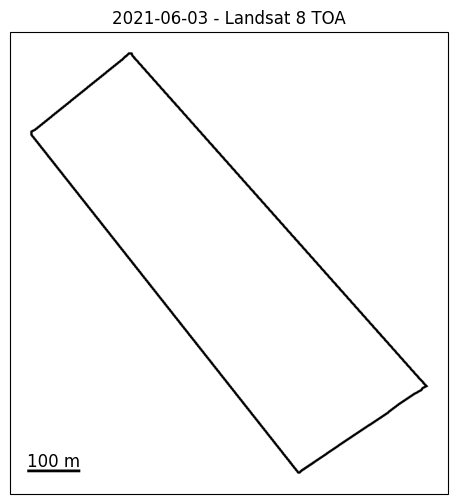

In [22]:
# Imagenes a plotear
ids_lista = df_l8_l9['ID GEE'].tolist()
# ids_lista = df_l8_l9[df_l8_l9['Mes']==6]['ID GEE'].tolist() # Filtrar por Mes X

path = 'output/imagenes/rgb landsat'

for img_id in ids_lista:

    # Imagen por id
    landsat_id = img_id[11:12]
    img_ee = ee.Image(img_id)
    img_ee_vis = img_ee.blend(roi_blend) # .clip(predios_agricolas)
    
    # Extraer datos de img
    img_date = img_ee.date().format('YYYY-MM-dd').getInfo()
    title_map = f'{img_date} - Landsat {landsat_id} TOA'
    save_fig = f'{path}/{img_date}_L{landsat_id}'

    # Gráfica con cartoee
    get_grafica_cartoee_color(img_ee_vis, 
                              vis_rgb, 
                              title_map=title_map,
                              nogrid=True,
                              save_fig=save_fig)

#### Imágenes Sentinel-2

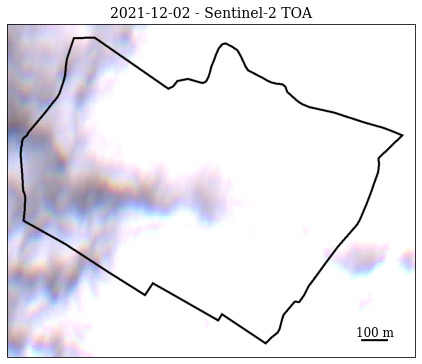

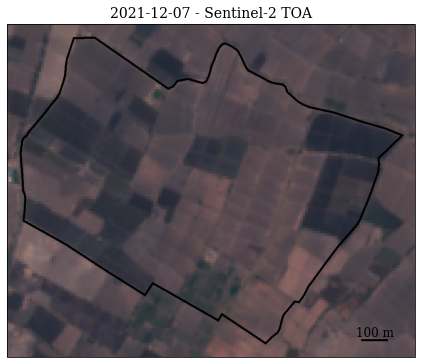

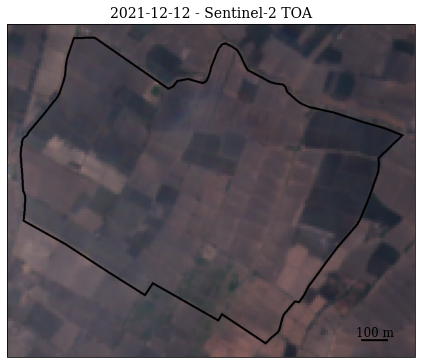

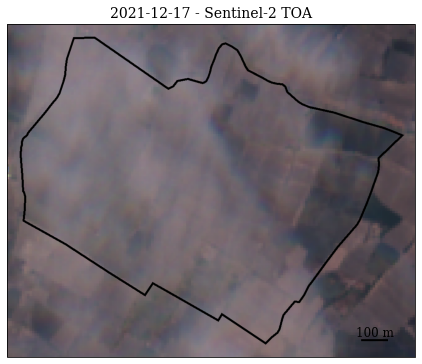

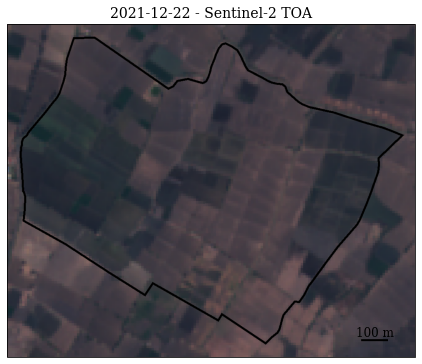

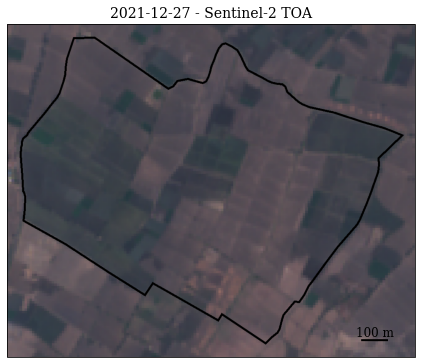

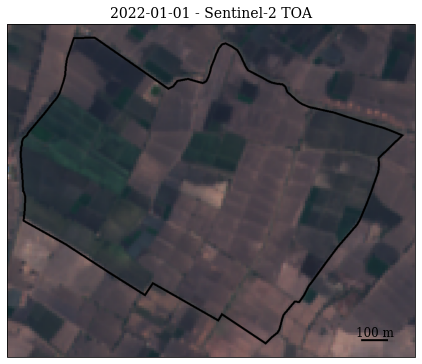

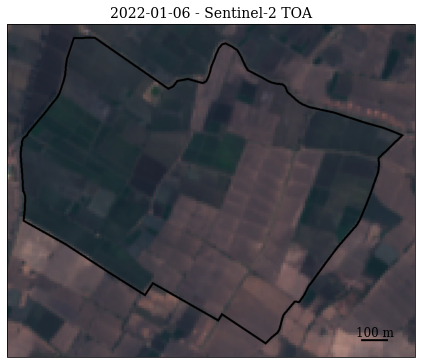

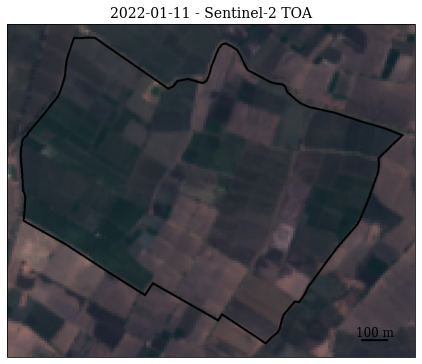

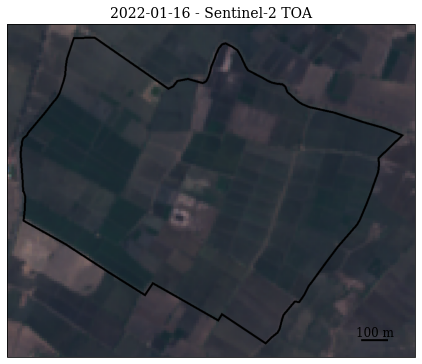

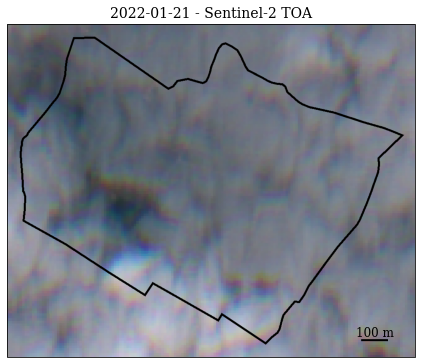

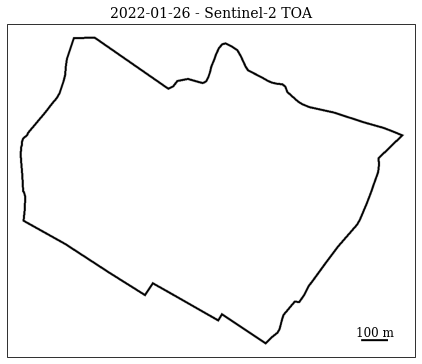

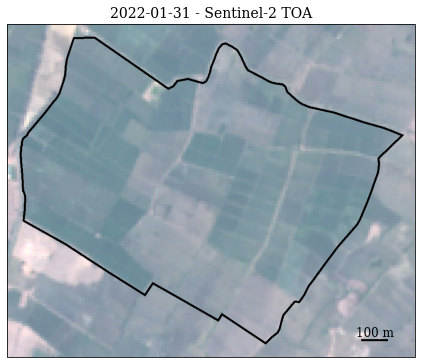

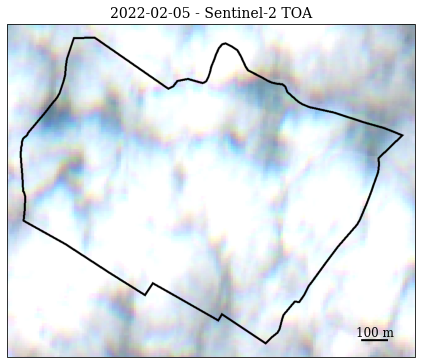

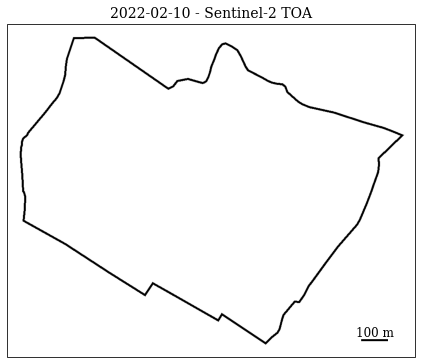

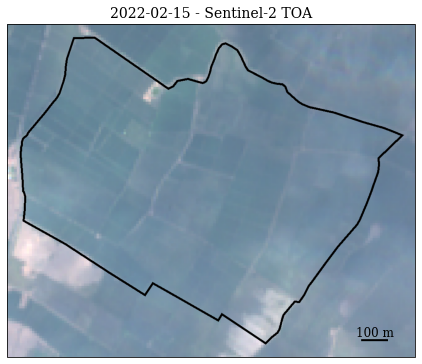

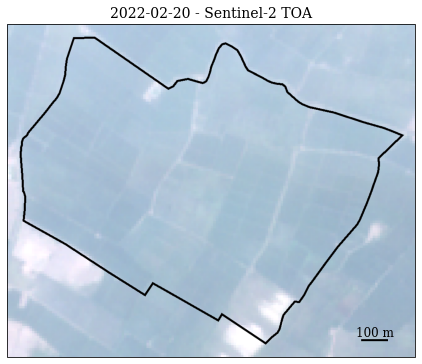

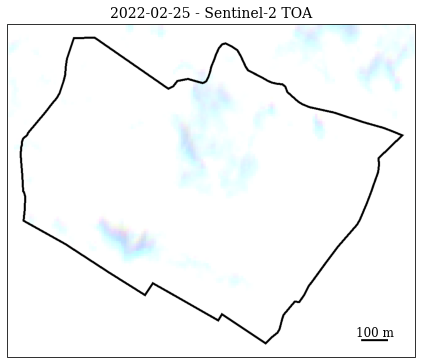

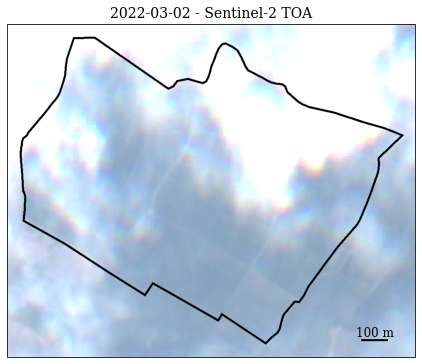

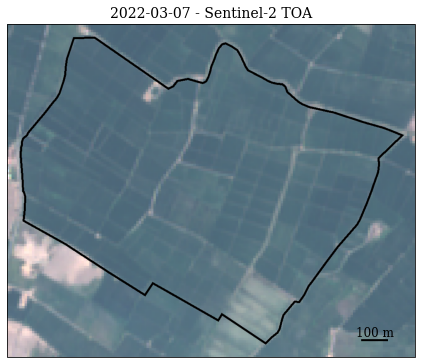

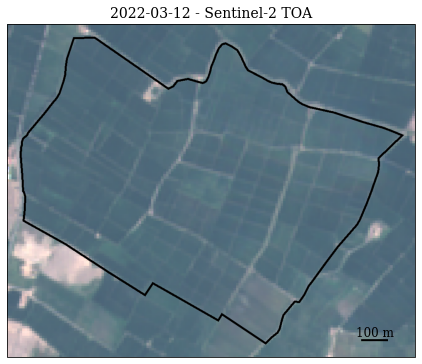

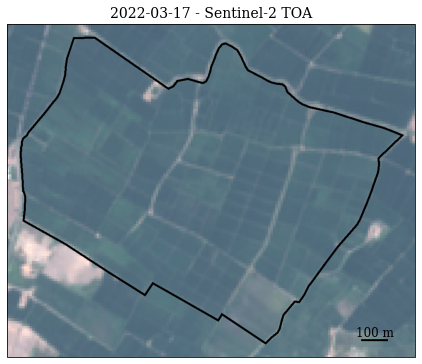

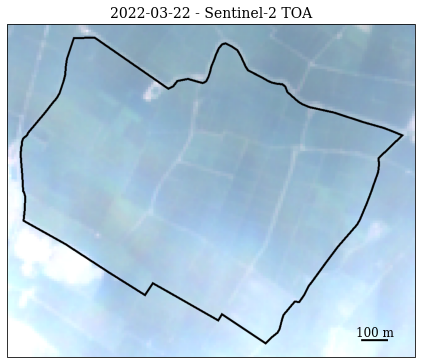

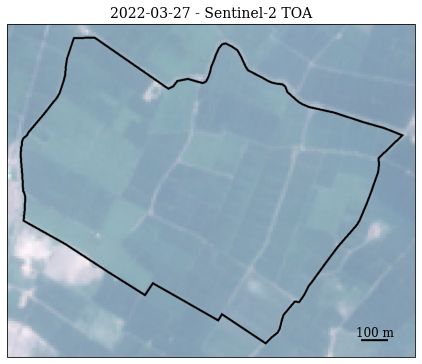

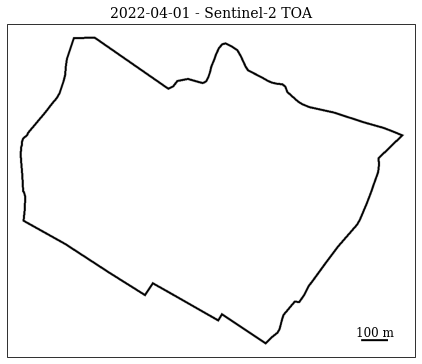

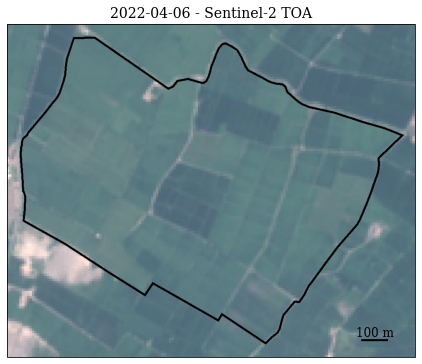

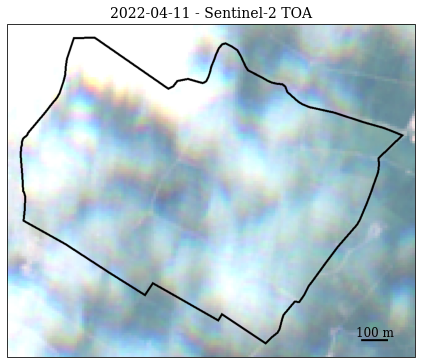

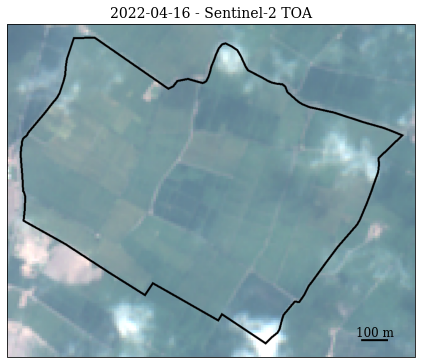

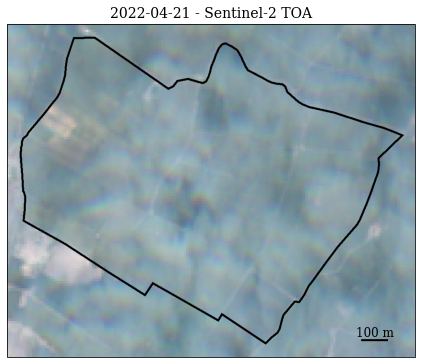

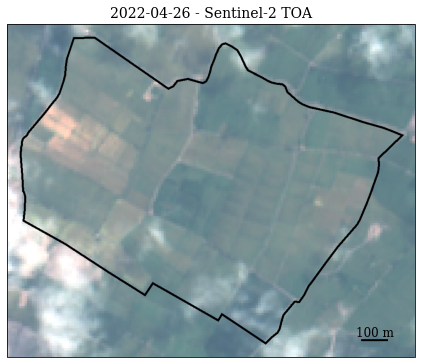

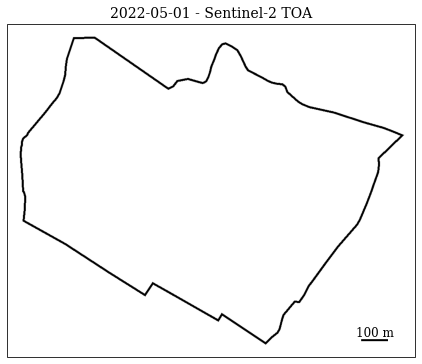

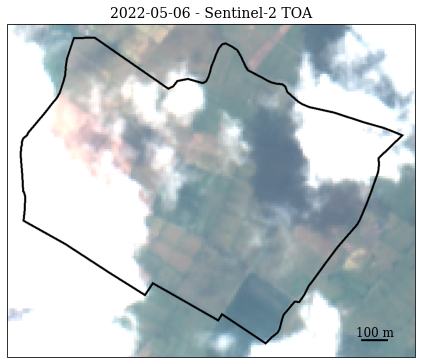

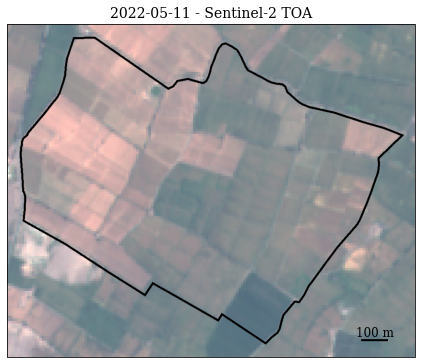

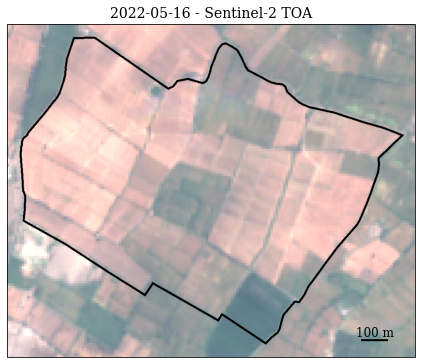

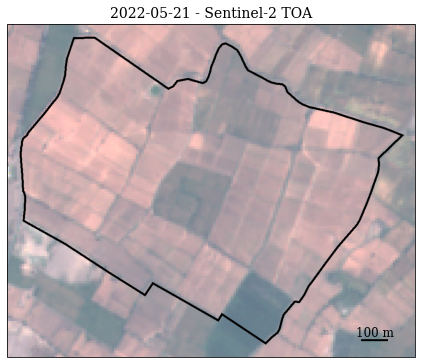

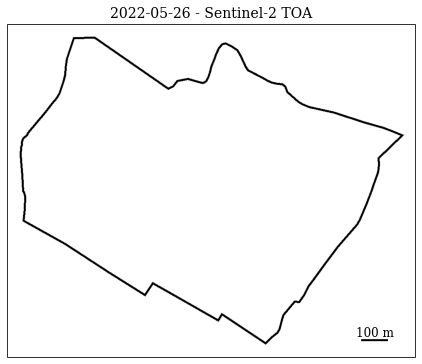

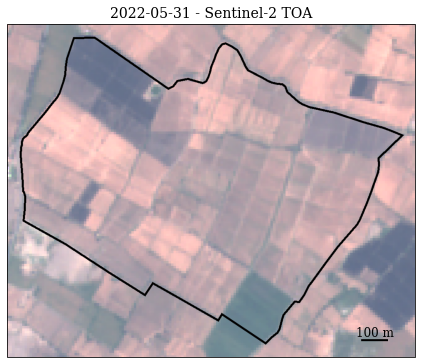

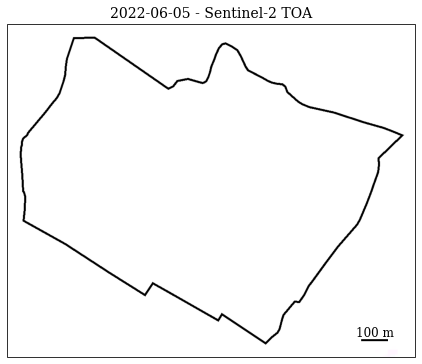

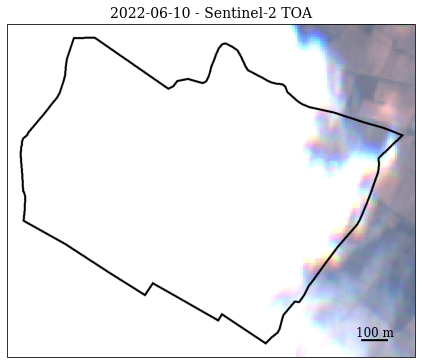

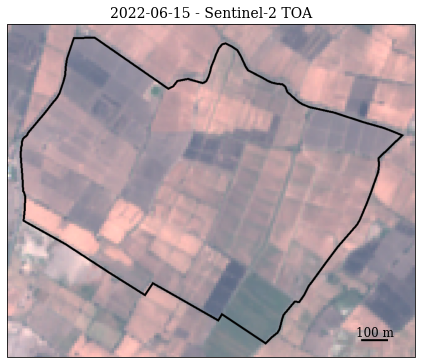

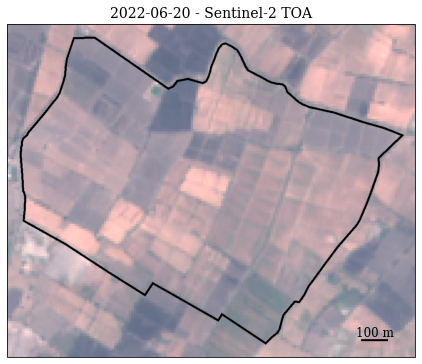

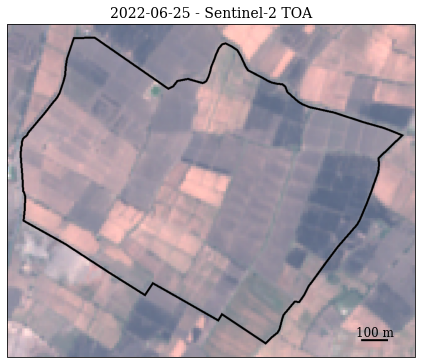

In [59]:
# Obtener gráficas para cada imagen
vis_params_sent = {'min': 0, 'max': 0.3, 'bands': ['B4','B3','B2'], 'gamma':0.6}

lista_ids = reporteS2['ID GEE'].tolist()
# lista_ids = reporteS2[reporteS2['Mes']==1]['ID GEE'].tolist()

path = 'D:/2025/Olivo_Tacna/METRIC/METRIC_PRUEBA/Grafico'

for img_id in lista_ids:
    
    img_sent = ee.Image(img_id)
    img_sent_vis = img_sent.multiply(0.0001).blend(roi_blend) # .clip(predios_agricolas)

    img_date = img_sent.date().format('YYYY-MM-dd').getInfo()
    title_map = f'{img_date} - Sentinel-2 TOA'
    save_fig = f'{path}/{img_date}_S2'
    
    get_grafica_cartoee_color(img_sent_vis, 
                              vis_params_sent, 
                              title_map=title_map,
                              nogrid=True,
                              save_fig=save_fig)

#### Pruebas

In [ ]:
# # Prueba: Recortar las imágenes de una carpeta en específico
# # Nota: Usar solo para recortar imágenes que lo necesiten y no olvidar borrar el archivo phototumb.db
# path = r'C:\Users\usuario\Documents\00-notebooks-2022\images\cartoee\RGB\Prueba_PLOTEO\recortados'
# list_imgs = os.listdir(path)
# # list_imgs

# import matplotlib.image as mpimg

# plt.figure(1)
# for i in range(len(list_imgs)):
#     img_path = path+"\\"+list_imgs[i]
#     img = mpimg.imread(img_path)[25:335,:] # Con grilla
#     # img = mpimg.imread(img_path)[0:330,:] # Sin grilla
#     plt.imsave(img_path, img) # https://www.delftstack.com/howto/numpy/save-numpy-array-as-image/